# Feature engineering
### Stellar Classification Dataset - SDSS17
https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS\
alpha = Right Ascension angle (at J2000 epoch)\
delta = Declination angle (at J2000 epoch)\
u = Ultraviolet filter in the photometric system\
g = Green filter in the photometric system\
r = Red filter in the photometric system\
i = Near Infrared filter in the photometric system\
z = Infrared filter in the photometric system\
run_ID = Run Number used to identify the specific scan\
rereun_ID = Rerun Number to specify how the image was processed\
cam_col = Camera column to identify the scanline within the run\
field_ID = Field number to identify each field\
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)\
class = object class (galaxy, star or quasar object)\
redshift = redshift value based on the increase in wavelength\
plate = plate ID, identifies each plate in SDSS\
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken\
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation\

#### Citation
fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17.

Acknowledgements
The data released by the SDSS is under public domain. Its taken from the current data release RD17.

More information about the license: http://www.sdss.org/science/image-gallery/

### Wczytanie potrzebnych elementów i wstępna obróbka danych

Wczytanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import sklearn 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Kod z https://stackoverflow.com/a/49199019 generujący zawartość requiments.txt
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for i in range(len(requirements)):
    print(f'{requirements[i][0]}=={requirements[i][1]}')

imblearn==0.0
matplotlib==3.7.2
numpy==1.24.3
pandas==2.0.3
scikit-learn==1.2.2
seaborn==0.12.2


Wczytanie i korekta ramki danych

In [3]:
# Wczytanie danych
df_original = pd.read_csv("..\\dane\\star_classification.csv")
development_unit_df, test_sample_df = train_test_split(df_original, test_size=0.3, random_state=42)

# Usuwanie kolumn, które są skorelowane z innymi ze współczynnikiem 1
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'rerun_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'obj_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'plate']
# Usuwanie błędnej obserwacji
development_unit_df = development_unit_df[development_unit_df['u'] > 0]

development_unit_df.head()

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,MJD,fiber_ID
76513,130.932167,4.313411,20.13070,18.37146,17.49792,17.06977,16.77949,3015,3,112,1.337614e+18,GALAXY,0.155863,52650,165
60406,225.429599,33.172083,19.86315,18.93886,18.59344,18.46922,18.40977,3900,5,594,3.304619e+18,STAR,-0.000529,54652,374
27322,219.173525,55.511740,19.84785,17.60157,16.71511,16.41555,16.25413,3225,4,74,3.711097e+18,STAR,-0.000261,54909,475
53699,178.735461,36.044139,17.83635,16.47576,15.82407,15.45751,15.18434,4552,6,67,2.367855e+18,GALAXY,0.068444,53467,317
65412,192.807458,18.727770,24.27039,22.60266,20.47710,19.45898,19.08250,5314,1,105,6.596788e+18,GALAXY,0.540778,56065,510


### Używane funkcje

In [32]:
def standard_distribution_info(variable_name, shareX):
    fig, ax = plt.subplots(4, 1, sharex=shareX, figsize=(10, 5))
    sns.histplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.histplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.histplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.histplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=0.0)
    fig.show()

def standard_boxplot_info(variable_name, show_text):
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 5))
    sns.boxplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.boxplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.boxplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.boxplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=0.0)
    fig.show()
    if (show_text):
        boxplot_info(variable_name)
    
def boxplot_info(variable_name):
    # outliery są znajdywane za pomocą metody 1.5IQR
    print('All classes:')
    selected_df = df[variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('GALAXY:')
    selected_df = df[df['class']=='GALAXY'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('QSO:')
    selected_df = df[df['class']=='QSO'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('STAR:')
    selected_df = df[df['class']=='STAR'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    
def standard_correlation_visualisation(variable_name, limit, show_text):
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[:5], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[5:10], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[10:15], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[15:18], hue='class')
    plt.show()
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    df_correlation[variable_name].plot.bar(color='#17becf', ylim=(-1, 1), ax=ax[0, 0]).set(title='All classes correlations') 
    df_correlation_GALAXY[variable_name].plot.bar(color='#1f77b4', ylim=(-1, 1), ax=ax[0, 1]).set(title='GALAXY correlations')
    df_correlation_QSO[variable_name].plot.bar(color='#ff7f0e', ylim=(-1, 1), ax=ax[1, 0]).set(title='QSO correlations')
    df_correlation_STAR[variable_name].plot.bar(color='#2ca02c', ylim=(-1, 1), ax=ax[1, 1]).set(title='STAR correlations')
    ax[0, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[0, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    ax[1, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[1, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    fig.tight_layout(pad=5.0)
    fig.show()
    if (show_text):
        print('korelacja:')
        print('all_classes: \n%s' %df_correlation.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('GALAXY: \n%s' %df_correlation_GALAXY.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('QSO: \n%s' %df_correlation_QSO.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('STAR: \n%s' %df_correlation_STAR.sort_values(by=[variable_name], ascending=False)[variable_name])
        
def test_models(df, show_details):
    # Podział na dane do trenowania i dane do walidacji
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('class', axis=1), df['class'], test_size=0.2, random_state=42)

    print('Dokładności modeli:')
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("LogisticRegression", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("KNeighborsClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("RandomForestClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("DecisionTreeClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    # Dla dużej liczby kolumn ten model długo pracuje, dlatego został sprawdzony tylo dla ostatnich wyników.
#     model = svm.SVC(kernel='linear')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print("SVC:", accuracy)
#     if(show_details):
#         print(classification_report(y_test, y_pred))
    
    model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("MLPClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))

def test_models_train_on_balanced(df_tmp, show_details):
    
    y = df_tmp['class']
    df_tmp = df_tmp.drop('class', axis=1)
    smote = SMOTE()
    df_tmp, y_resampled = smote.fit_resample(df_tmp, y)
    df_tmp['class'] = pd.DataFrame(y_resampled)
    X_train, X_test, y_train, y_test = train_test_split(
        df_tmp.drop('class', axis=1), df_tmp['class'], test_size=0.2, random_state=42)
    

    print('Dokładności modeli:')
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("LogisticRegression", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("KNeighborsClassifier", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("RandomForestClassifier", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("DecisionTreeClassifier", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    # Dla dużej liczby kolumn ten model długo pracuje, dlatego został sprawdzony tylo dla ostatnich wyników.
#     model = svm.SVC(kernel='linear')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print("SVC:", accuracy)
#     if(show_details):
#         print(classification_report(y_test, y_pred))
    
    model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("MLPClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))


# Inżynieria cech

### Pierwsza iteracja

In [5]:
df = development_unit_df.copy()

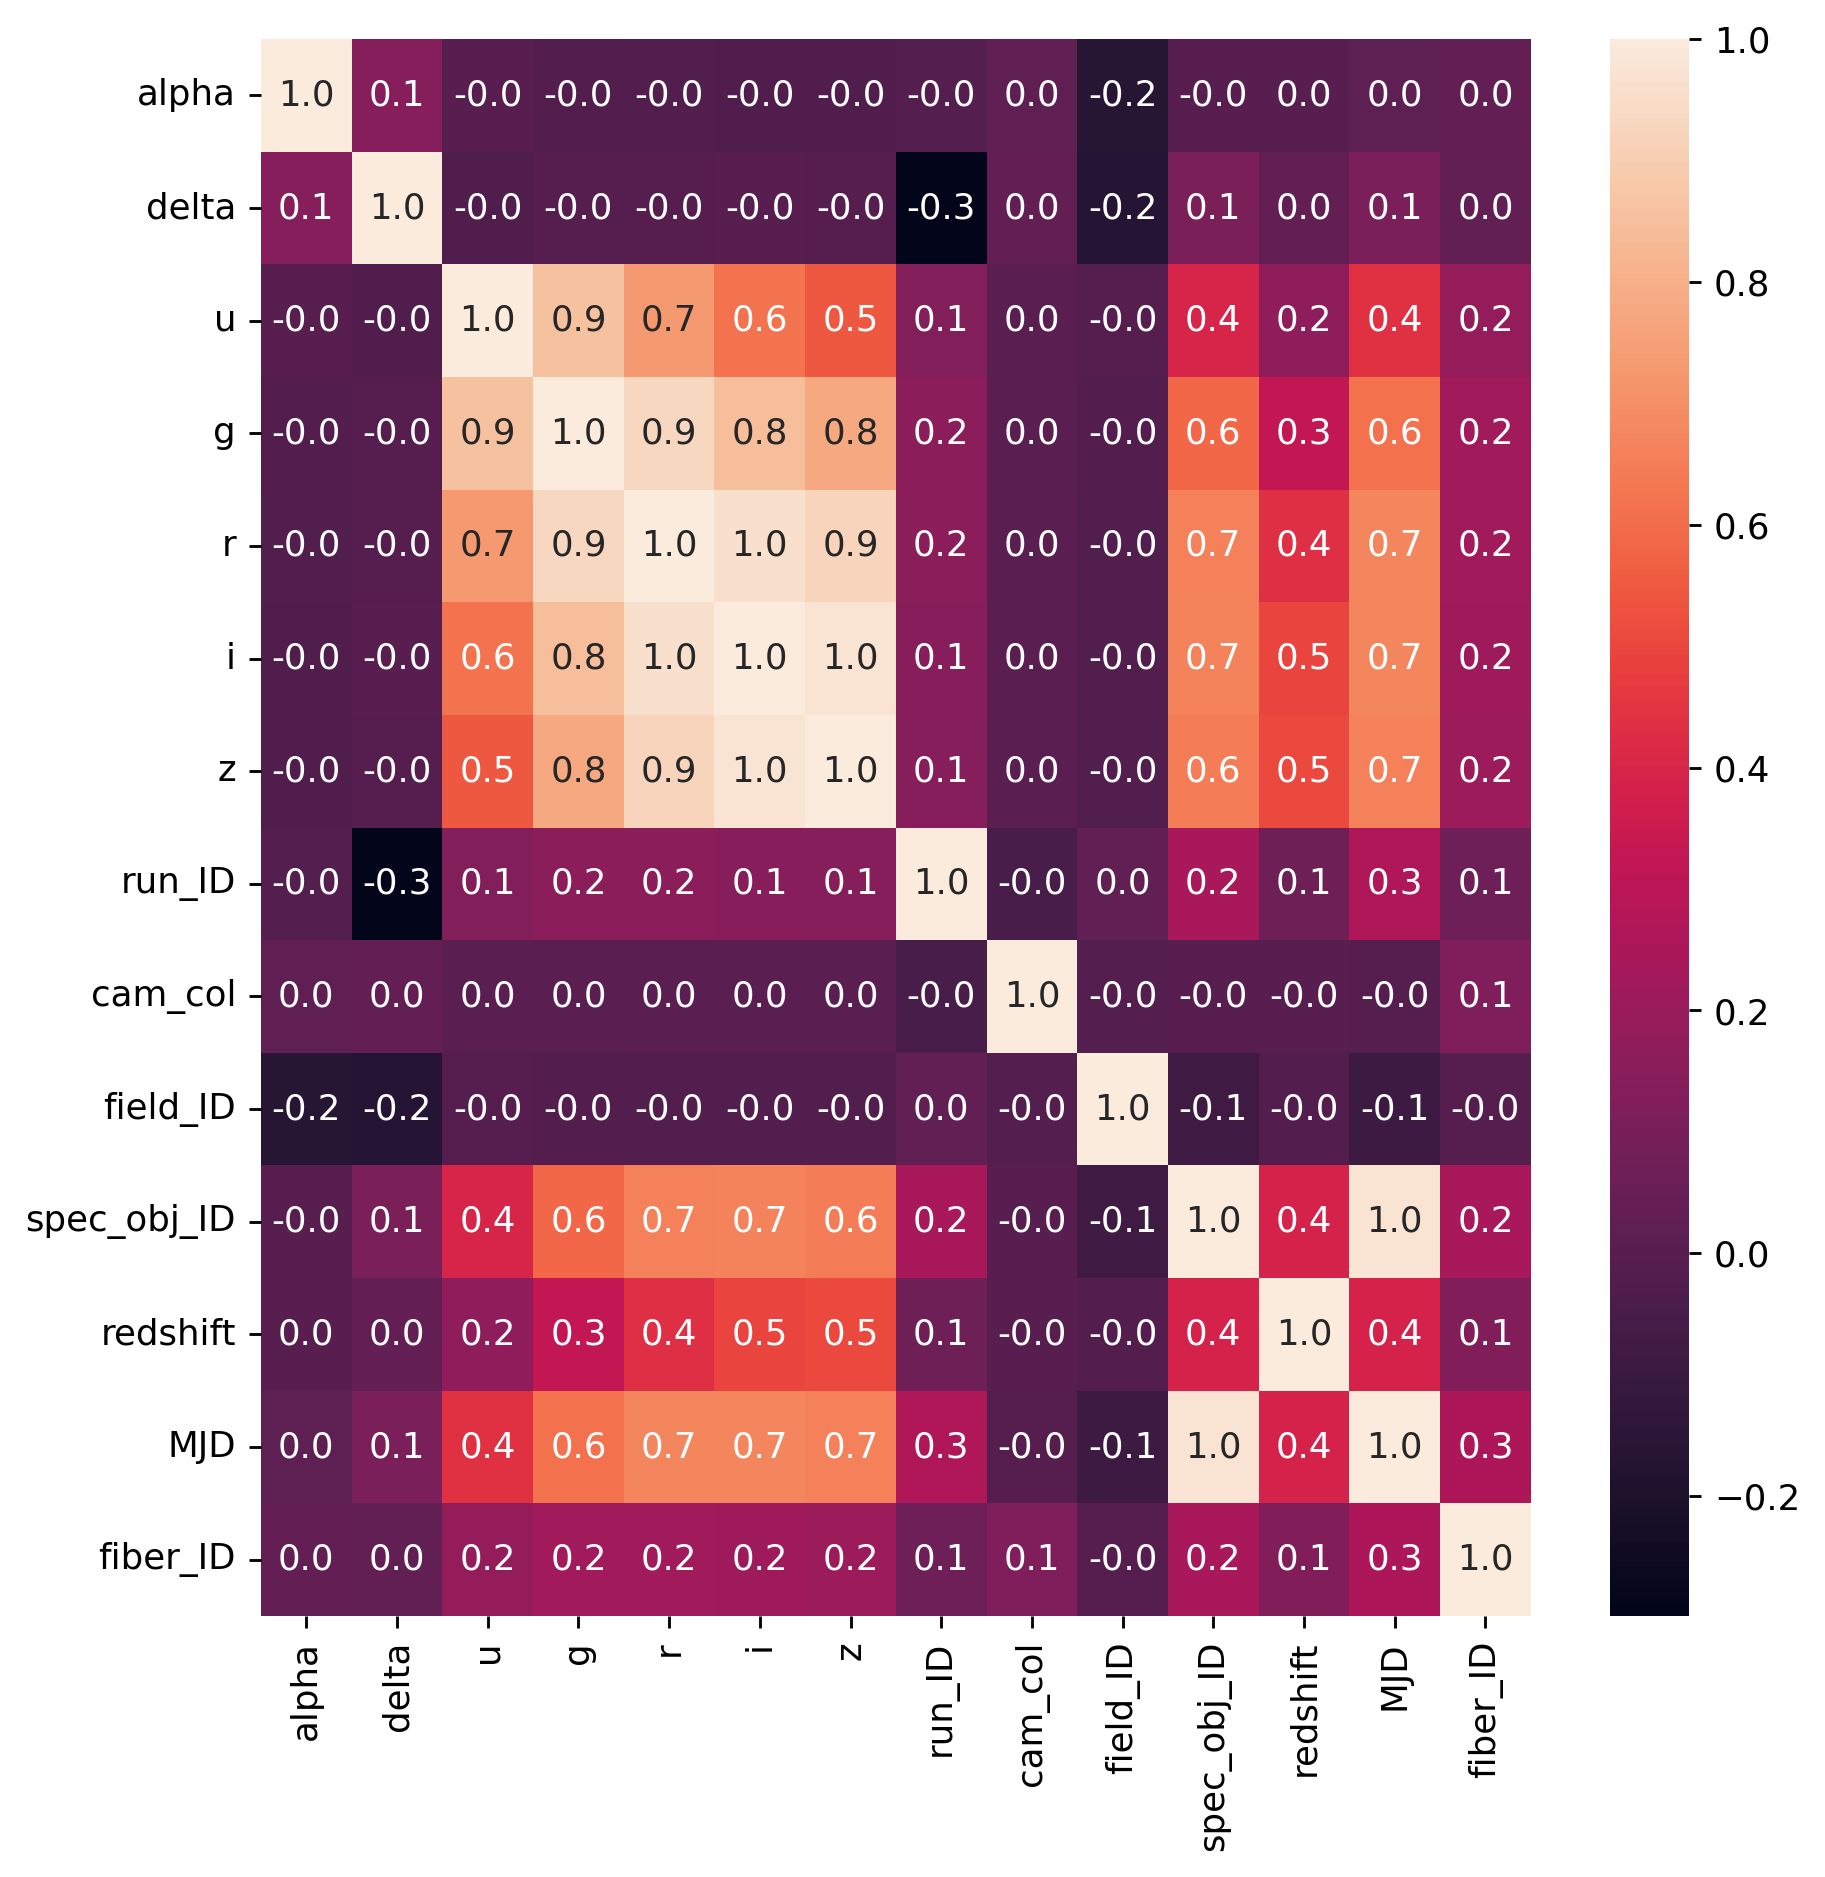

In [6]:
## jeszcze raz macierz korelacji -> widzimy, że usunęliśmy najbardziej skorelowane kolumny
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

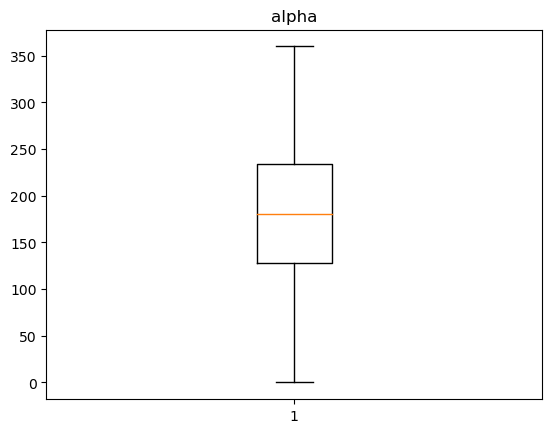

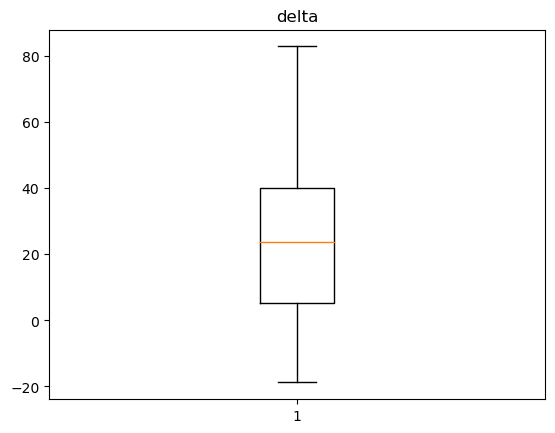

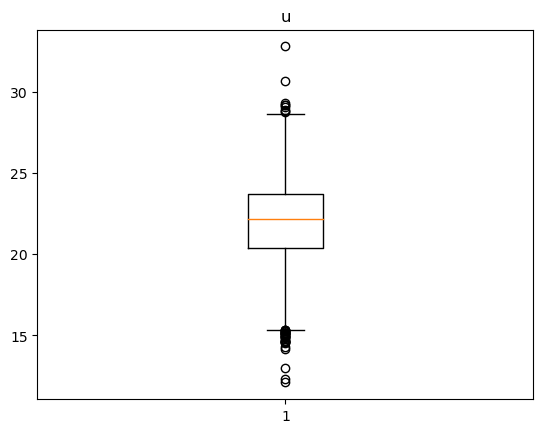

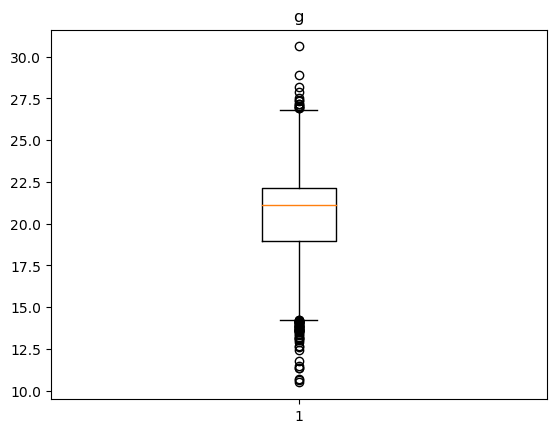

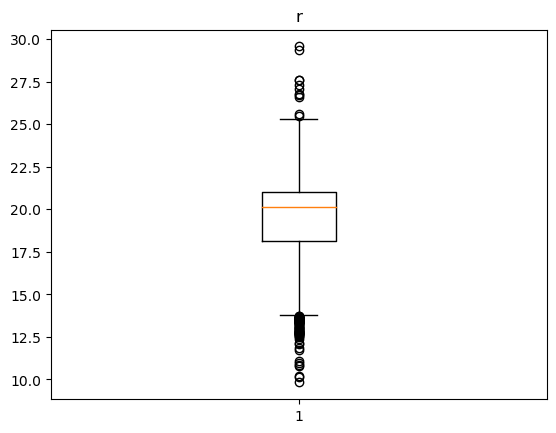

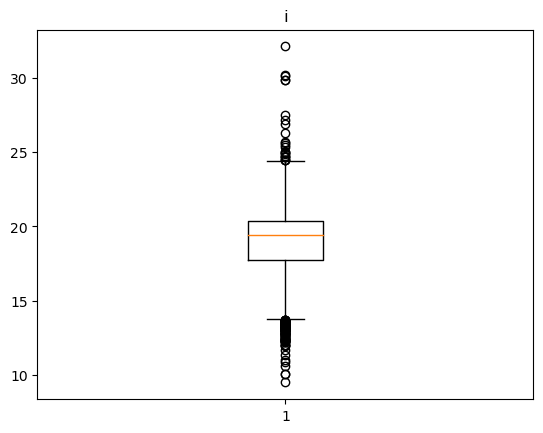

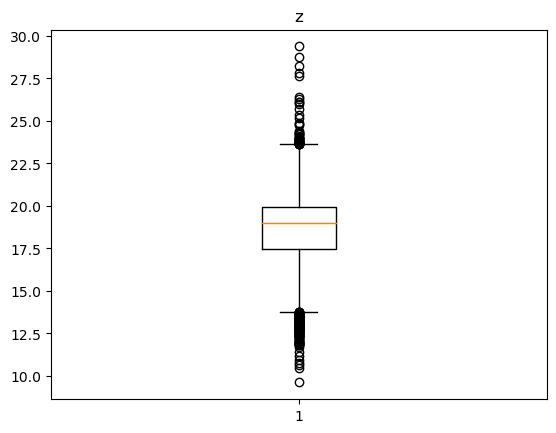

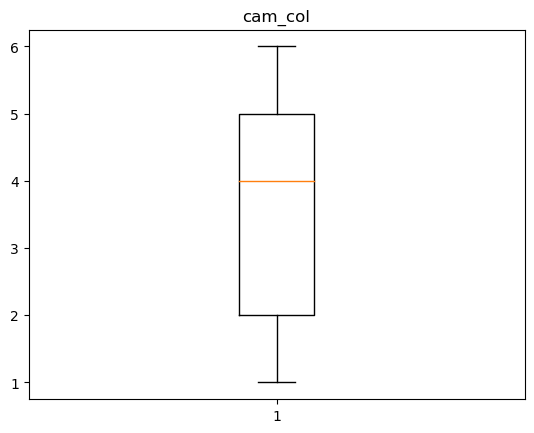

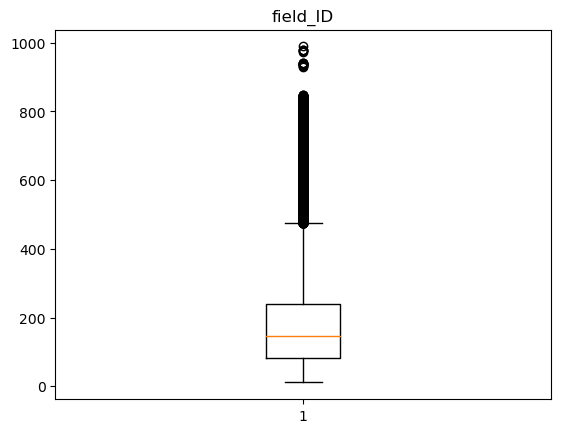

In [7]:
## usuwanie OUTLIERS: zobaczmy, dla których zmiennych wystąpują wartości odstające
for i in range(10):
    if i != 7:
        plt.boxplot(df.iloc[:, i])
        plt.title(df.columns[i])
        plt.show()

In [8]:
### przyjrzyjmy się outlierom w kolumnach 'u', 'r' jeszcze raz:
columns_to_be_checked = ['r', 'u']

for i in range(len(columns_to_be_checked)):
    column = df[columns_to_be_checked[i]]
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)

    IQR = Q3 - Q1

    outliers = (column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))

    outliers_count = outliers.sum()

    outliers_percentage = outliers.mean() * 100
    df = df[~outliers]
    print(outliers_count)
    print("Ilość outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_count)
    print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_percentage)
    
    ## usuńmy outliery dla u i r: stanowią tylko 0.13% i 0.03% wszystkich wierszy

92
Ilość outlierów dla kolumny  r :  92
Procentowy udział outlierów dla kolumny  r :  0.13142857142857142
16
Ilość outlierów dla kolumny  u :  16
Procentowy udział outlierów dla kolumny  u :  0.02288722320764433


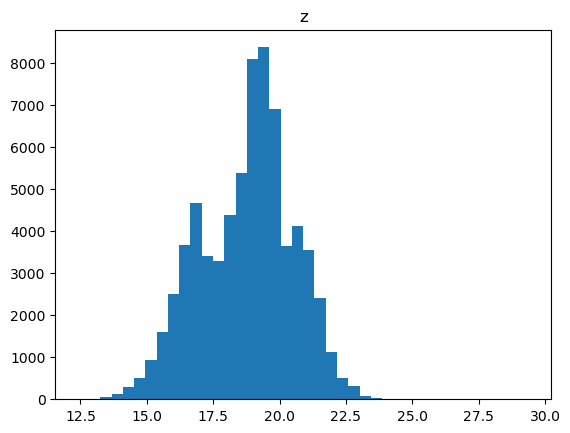

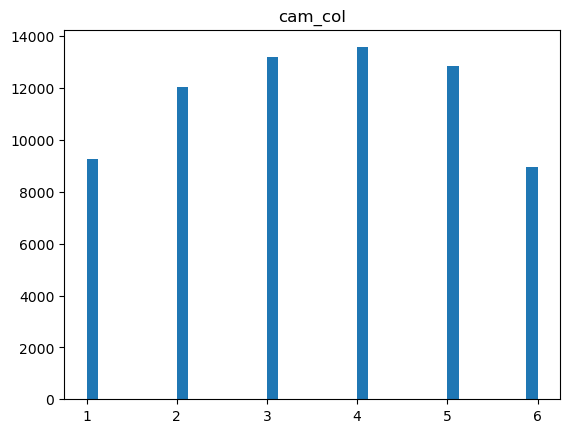

In [9]:
### spójrzmy jeszcze na dwie pozostałe kolumny z outlierami:

plt.hist(df.iloc[:, 6], bins = 40)
plt.title(df.columns[6])
plt.show()

plt.hist(df.iloc[:, 8], bins = 40)
plt.title(df.columns[8])
plt.show()

# zmienne redshift oraz filed_ID mają rozkład wykładniczy -> chyba nie usuwamy outlierów ???

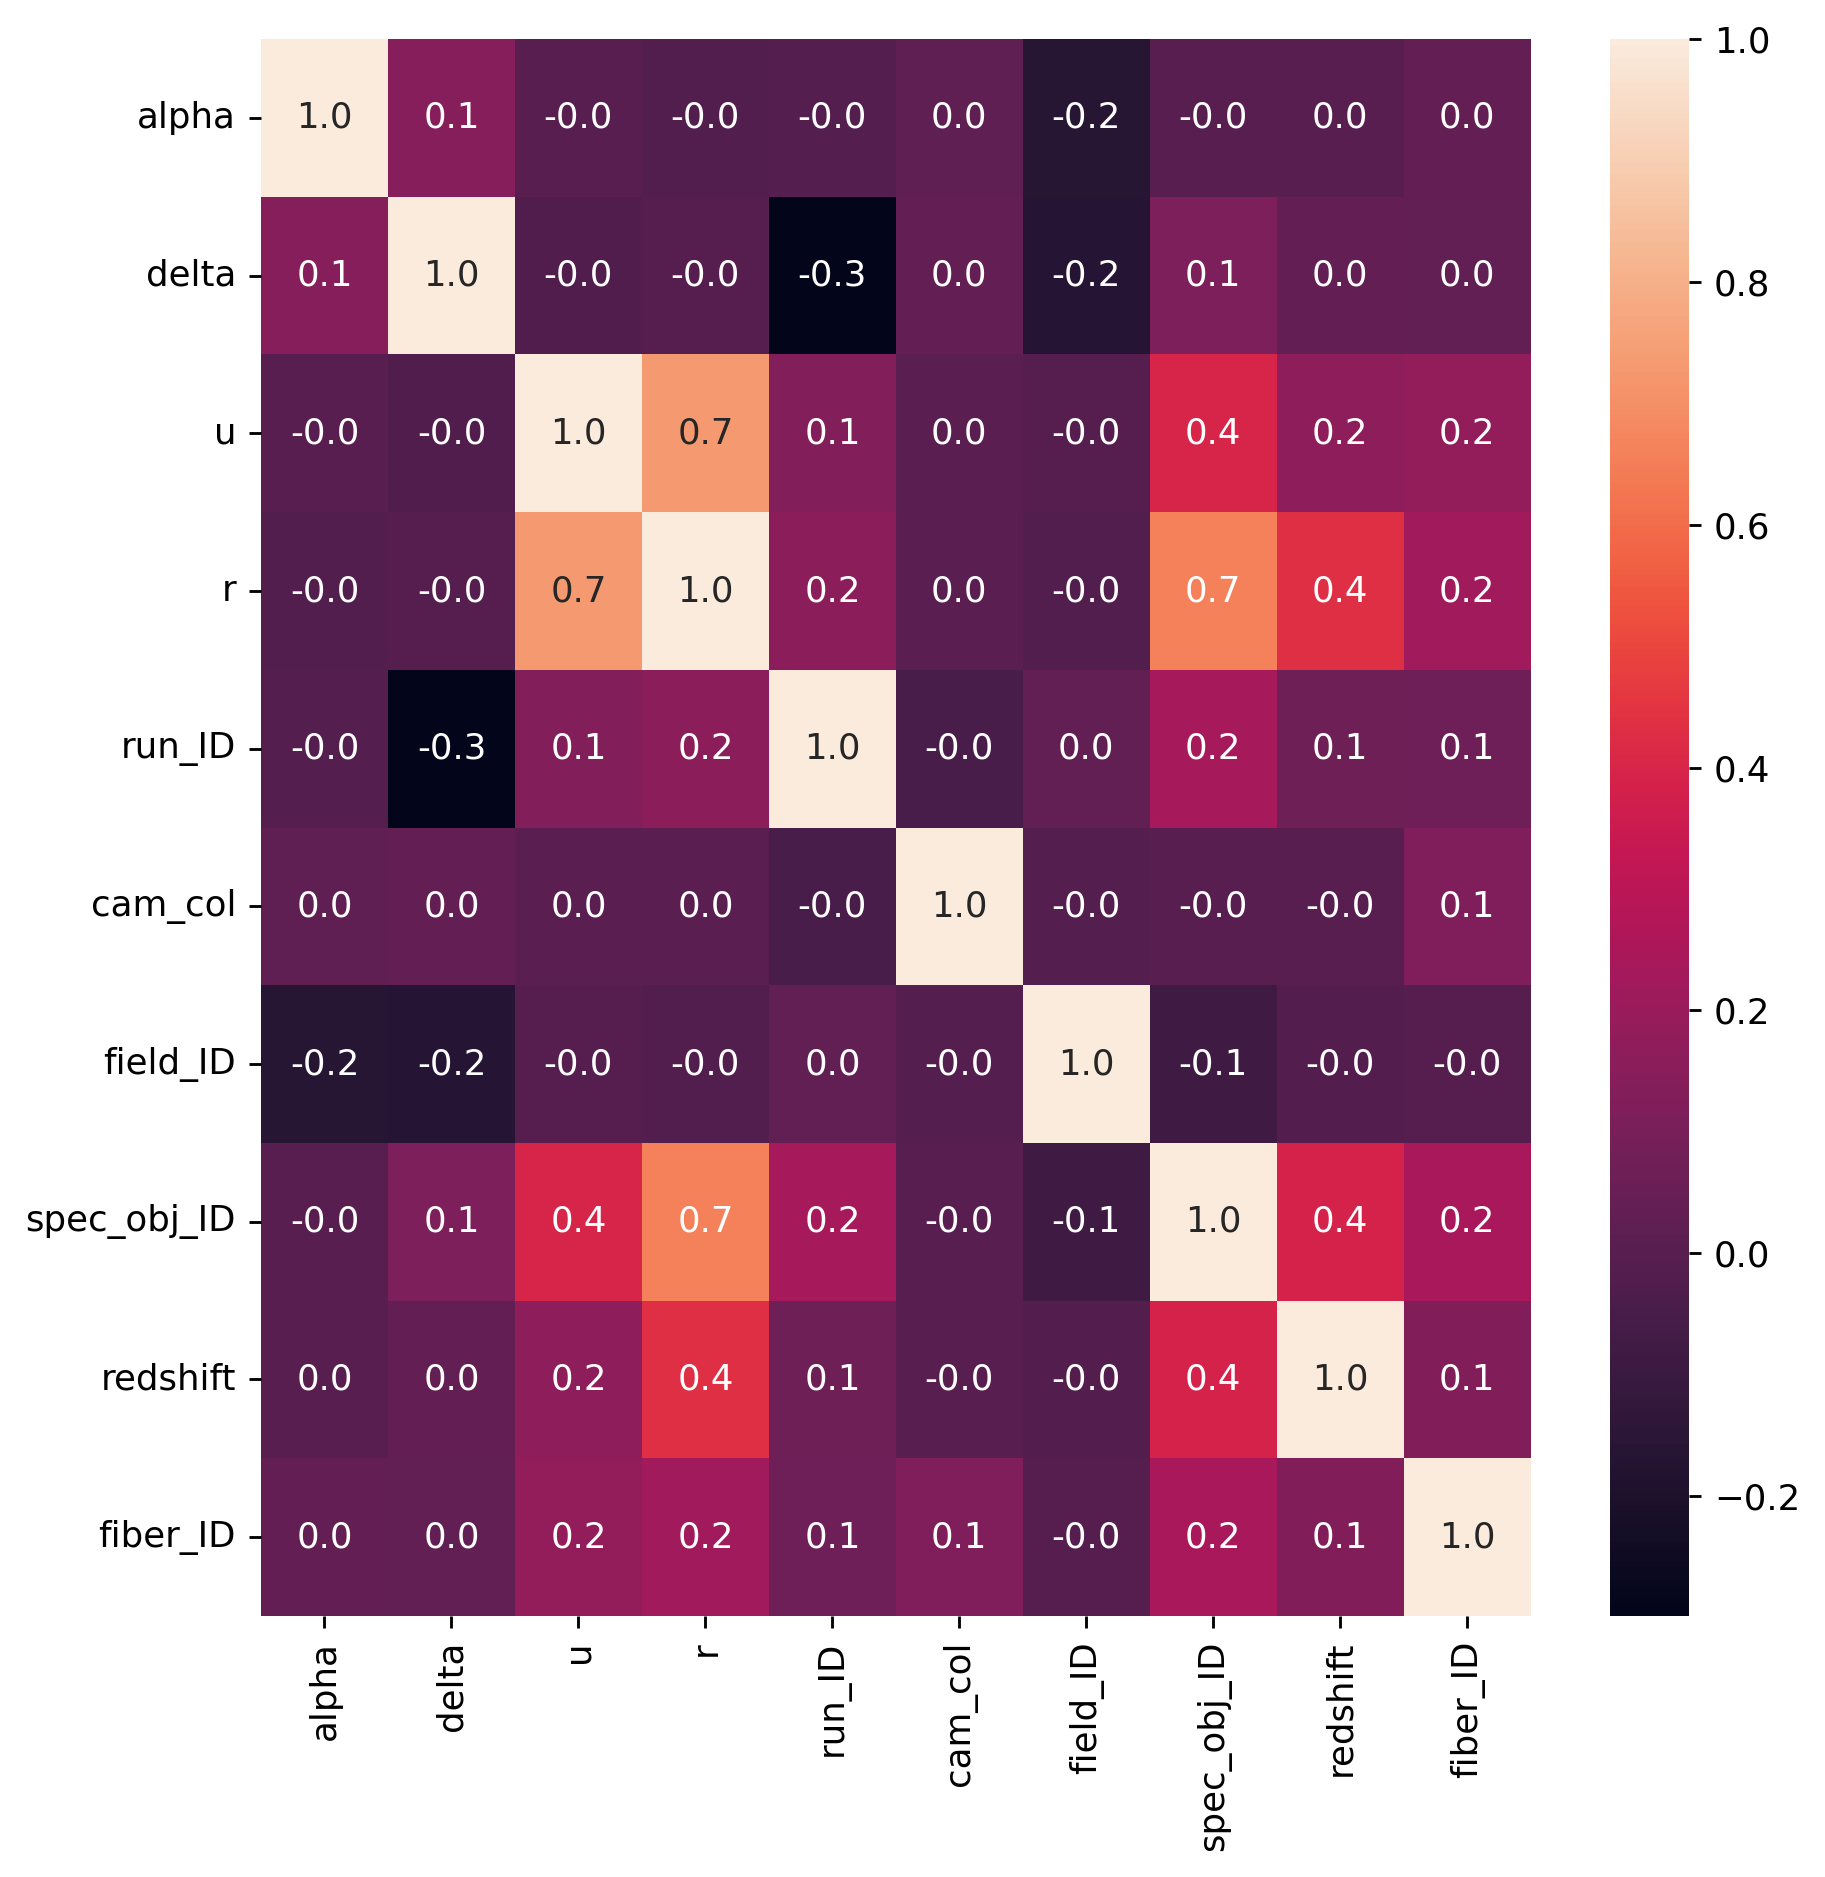

In [10]:
df = df.drop(['i', 'g', 'z', 'MJD'], axis = 1)
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

In [11]:
# Tworzenie kopii ramki danych

# Modefikowanie cech

# Usuwanie kolumn

# Korekta outlierów

# Zrównoważenie
y = df['class']
df = df.drop('class', axis=1)
smote = SMOTE()
df, y_resampled = smote.fit_resample(df, y)
df['class'] = pd.DataFrame(y_resampled)

# Normalizacja
columns_to_standardize = ['run_ID', 'fiber_ID', 'alpha', 'delta', 'redshift', 'spec_obj_ID', 'cam_col', 'u', 'r', 'field_ID']
df[columns_to_standardize] = MinMaxScaler().fit_transform(df[columns_to_standardize])

# Standaryzacja
columns_to_normalize = ['u']
df[columns_to_normalize] = StandardScaler().fit_transform(df[columns_to_normalize])

# Informacje o ramce danych
df.describe()

,alpha,delta,u,r,run_ID,cam_col,field_ID,spec_obj_ID,redshift,fiber_ID
count,124593.000000,124593.000000,1.245930e+05,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000
mean,0.492901,0.427002,5.347049e-16,0.514739,0.540837,0.481462,0.174414,0.414832,0.103316,0.449422
std,0.270106,0.194716,1.000004e+00,0.152044,0.242043,0.305054,0.142879,0.244897,0.126093,0.260627
min,0.000000,0.000000,-3.109817e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.347777,0.238106,-7.043861e-01,0.407954,0.381969,0.200000,0.074642,0.201849,0.001429,0.236236
50%,0.501936,0.429790,-1.089354e-02,0.554709,0.499938,0.400000,0.138037,0.398927,0.063418,0.432432
75%,0.653984,0.587911,6.638226e-01,0.629424,0.662113,0.800000,0.228016,0.605155,0.172057,0.636637
max,1.000000,1.000000,3.321956e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Testowanie

In [12]:
test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9297724627794053
KNeighborsClassifier: 0.8491512500501626
RandomForestClassifier: 0.9789718688550905
DecisionTreeClassifier: 0.9653276616236607
MLPClassifier: 0.9375576869055741


Wnioski
- przy zamianie outlierow z kolumn field_ID, redshift lub ich usunięciu, dokładności przykładowych 
modeli spadają do około 40 - 50 %
- normalizacja przed standaryzacją daje gorsze wyniki, bez standaryzacji zmiennej u też są gorsze wyniki
- można się jeszcze zastanowić nad usunięciem zmiennej 'r' ponieważ ma ona korelację z zmienną 'u' równą 0.73 
(co jest dosyć sporo) + bez tej zmiennej model ma porównywalną precyzyjność

## Macierz korelacji dla ramki bez modefiakcji

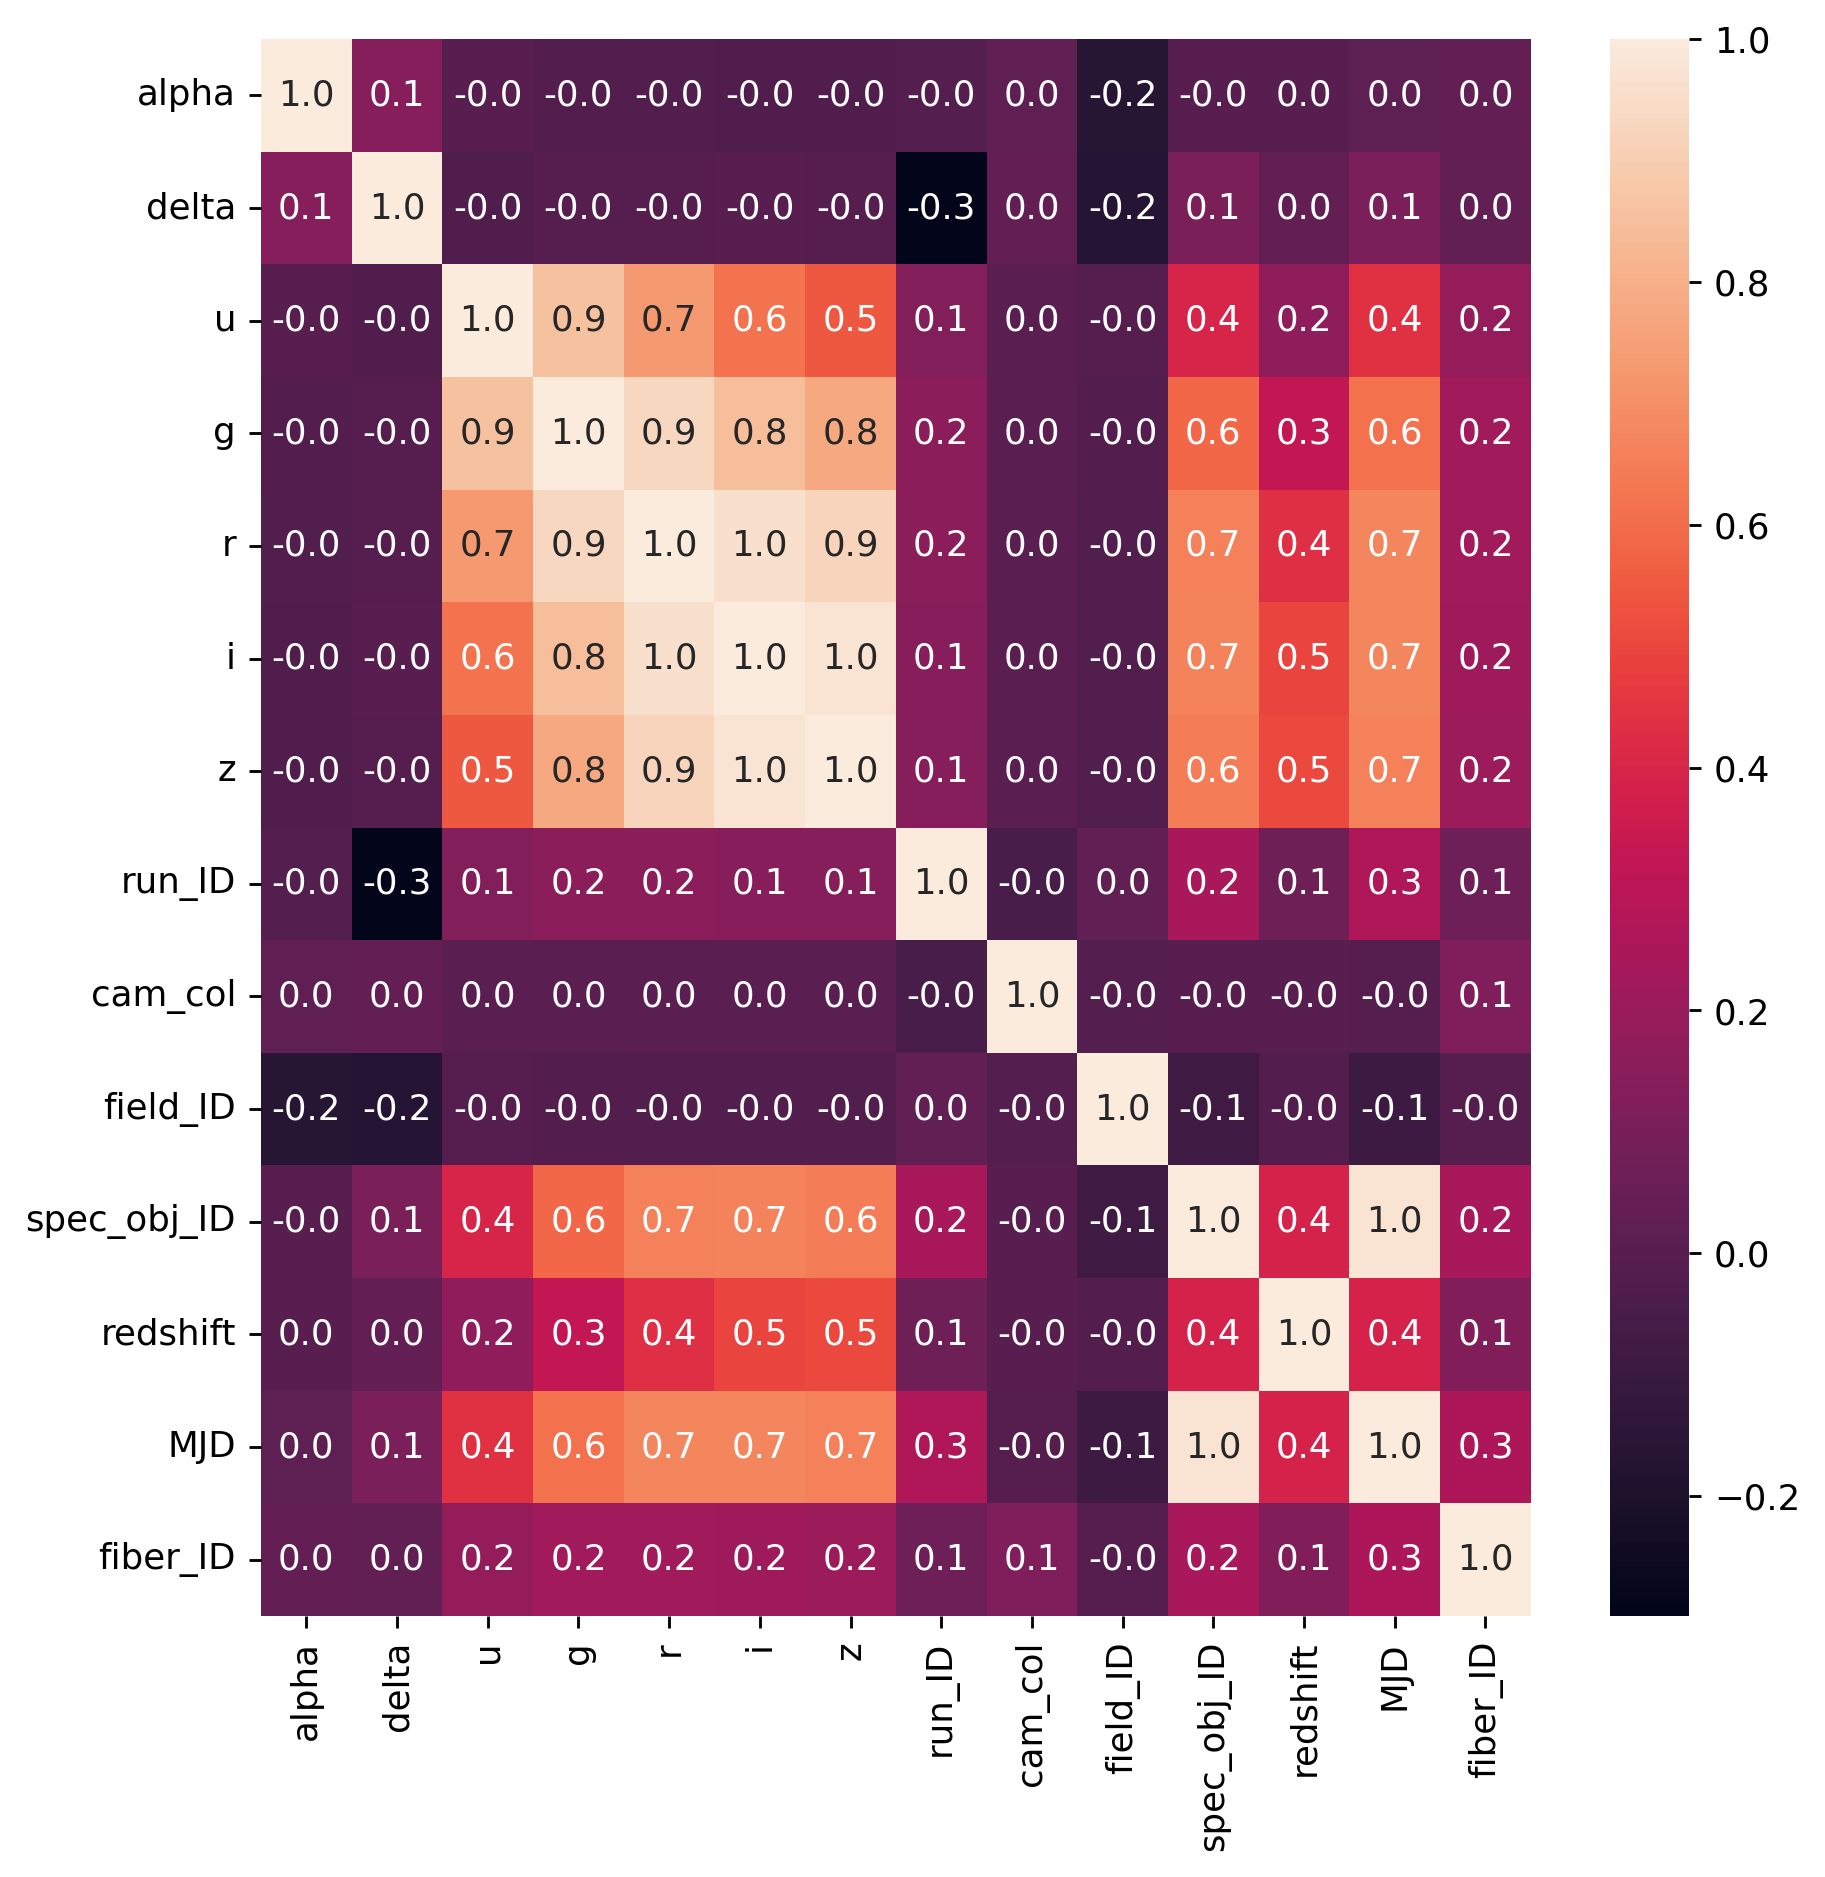

In [13]:
df = development_unit_df.copy()
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

Standaryzacja jest zalecana dla cech o rozkładzie podobnym do narmalnego i zawierających wartości odstające.
Do tych kolumn należą:rerun obj plate
- delta
- u
- g
- r
- i
- z
- redshift
- field_ID

Pozostałe można poddać normalizacji:
- alpha
- run_ID 
- cam_col
- spec_obj_ID
- MJD
- fiber_ID

## Bez modefikacji

In [14]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech

# Usuwanie kolumn

# Korekta outlierów

# Zrównoważenie

# Normalizacja

# Standaryzacja

# Informacje o ramce danych

# Testowanie
test_models(df, True)

Dokładności modeli:
LogisticRegression 0.5947857142857143
              precision    recall  f1-score   support

      GALAXY       0.59      1.00      0.75      8327
         QSO       0.00      0.00      0.00      2627
        STAR       0.00      0.00      0.00      3046

    accuracy                           0.59     14000
   macro avg       0.20      0.33      0.25     14000
weighted avg       0.35      0.59      0.44     14000

KNeighborsClassifier: 0.7056428571428571
              precision    recall  f1-score   support

      GALAXY       0.74      0.89      0.81      8327
         QSO       0.50      0.39      0.44      2627
        STAR       0.76      0.47      0.58      3046

    accuracy                           0.71     14000
   macro avg       0.67      0.58      0.61     14000
weighted avg       0.70      0.71      0.69     14000

RandomForestClassifier: 0.9778571428571429
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.

## Usunięcie silnie skorelowanych kolumn

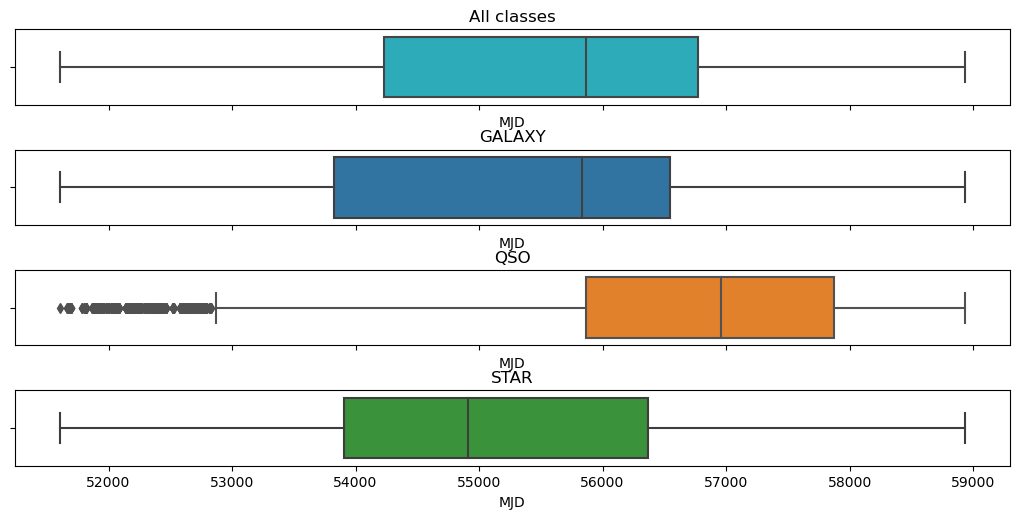

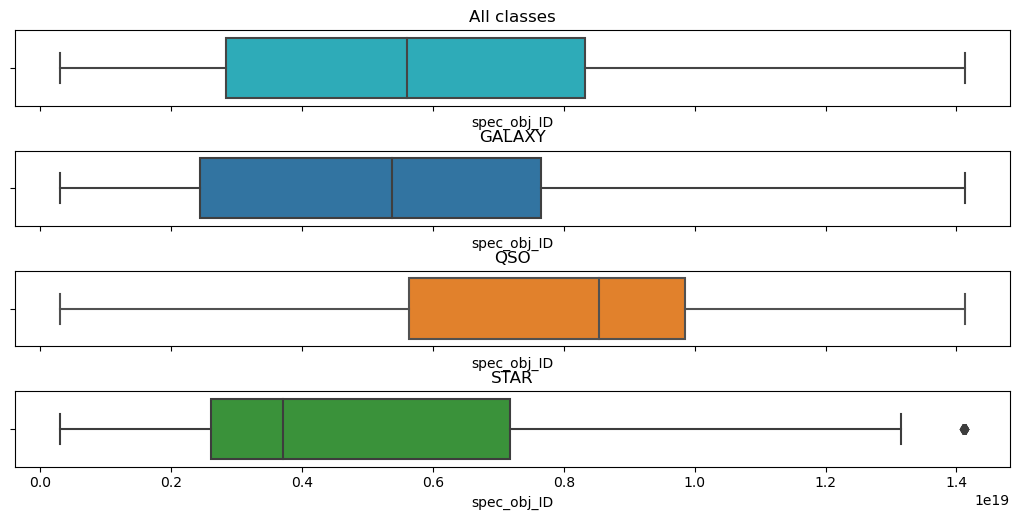

In [15]:
df = development_unit_df.copy()
standard_boxplot_info('MJD', False)
standard_boxplot_info('spec_obj_ID', False)

In [16]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech

# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1) # korelacja =~1 z spec_obj_ID, lepsze wyniki testów z daną zmienną mieszczą się w granicach niepewności 
df = df.drop(['g', 'r', 'i', 'z'], axis = 1)

# Korekta outlierów

# Zrównoważenie

# Normalizacja

# Standaryzacja

# Informacje o ramce danych

test_models(df, False)

Dokładności modeli:
LogisticRegression 0.5947857142857143
KNeighborsClassifier: 0.7056428571428571
RandomForestClassifier: 0.975
DecisionTreeClassifier: 0.9555714285714285
MLPClassifier: 0.5947857142857143


## Usunięcie silnie skorelowanych cech + normalizacja/standaryzacja

In [17]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech

# Korekta outlierów

# Zrównoważenie

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID',]
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])

# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['g', 'r', 'i', 'z'], axis = 1)

df.describe()

,alpha,delta,u,run_ID,cam_col,field_ID,spec_obj_ID,redshift,fiber_ID
count,70000.000000,7.000000e+04,7.000000e+04,70000.000000,70000.000000,7.000000e+04,70000.000000,7.000000e+04,70000.000000
mean,0.493114,5.156510e-17,1.393070e-15,0.542195,0.501829,5.684342e-18,0.396223,2.781267e-17,0.448349
std,0.267455,1.000007e+00,1.000007e+00,0.243685,0.317937,1.000007e+00,0.240704,1.000007e+00,0.272808
min,0.000000,-2.184098e+00,-4.430286e+00,0.000000,0.000000,-1.175390e+00,0.000000,-8.024834e-01,0.000000
25%,0.354708,-9.624684e-01,-7.680634e-01,0.381845,0.200000,-6.964982e-01,0.183697,-7.148356e-01,0.220220
50%,0.501623,-2.475940e-02,4.202526e-02,0.506519,0.600000,-2.648207e-01,0.383757,-2.105143e-01,0.431431
75%,0.649092,8.024842e-01,7.145273e-01,0.647833,0.800000,3.624607e-01,0.580566,1.745549e-01,0.643644
max,1.000000,2.982636e+00,4.748834e+00,1.000000,1.000000,5.421182e+00,1.000000,8.795777e+00,1.000000


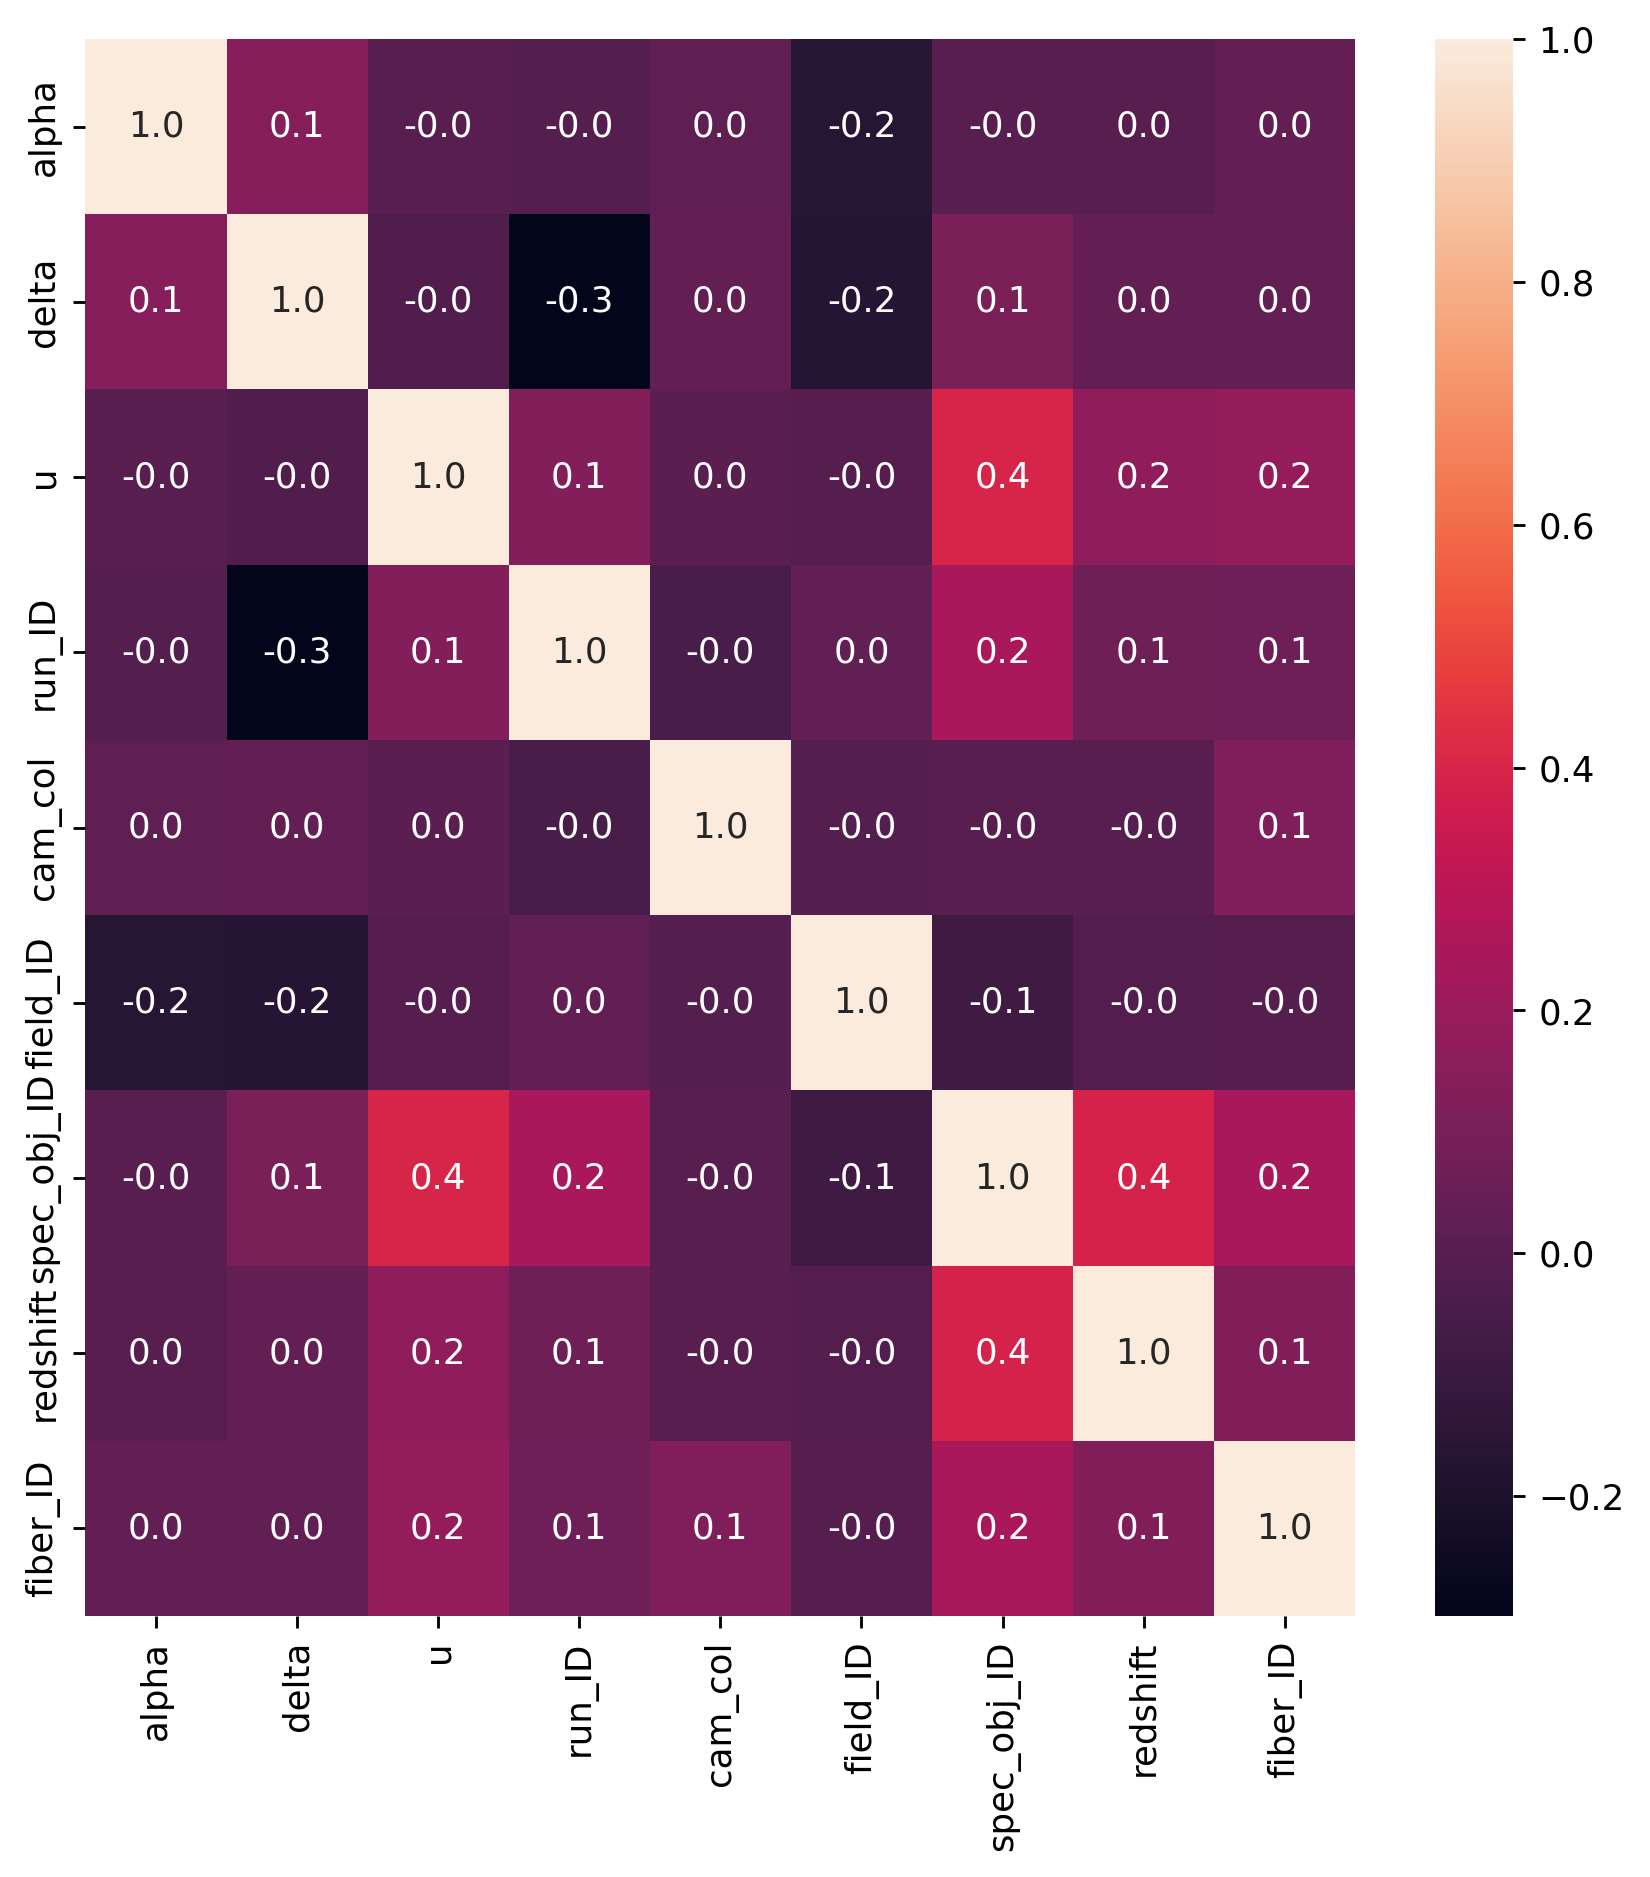

In [18]:
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

In [19]:
test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9508571428571428
KNeighborsClassifier: 0.9192142857142858
RandomForestClassifier: 0.9749285714285715
DecisionTreeClassifier: 0.9556428571428571
MLPClassifier: 0.9665


### Modefikacja cech opisujących filtry

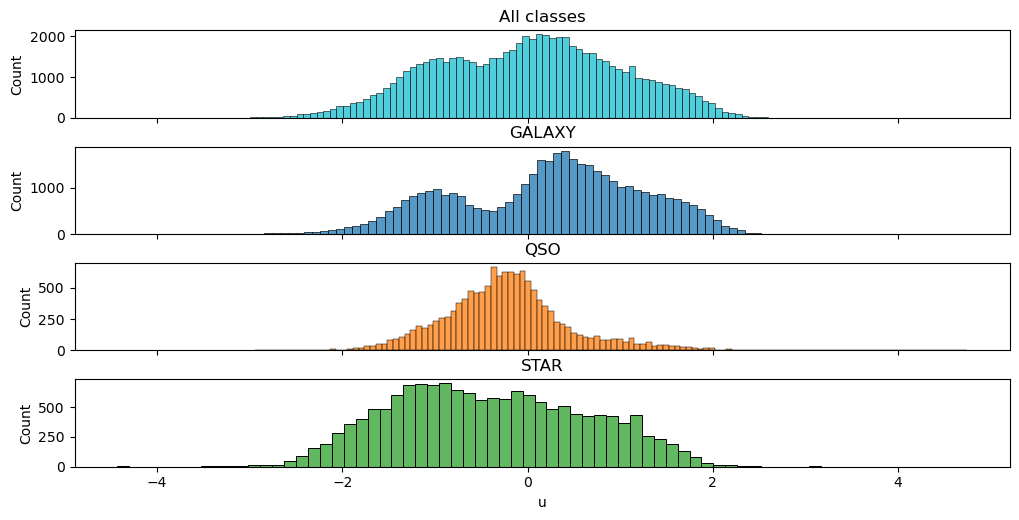

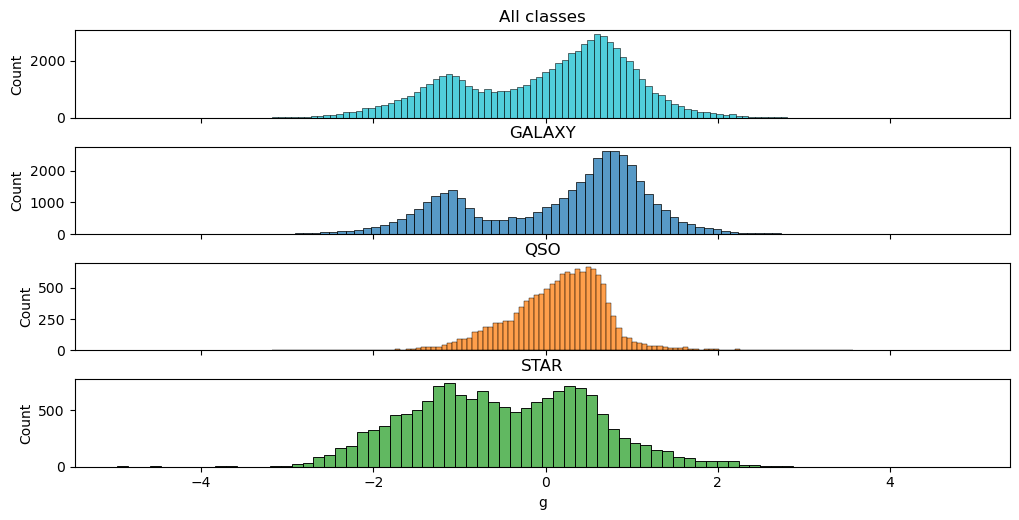

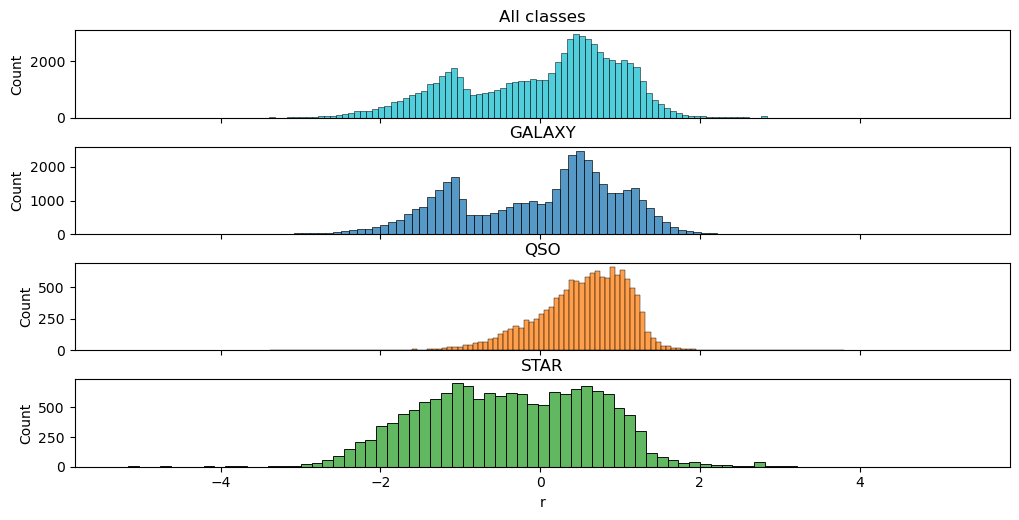

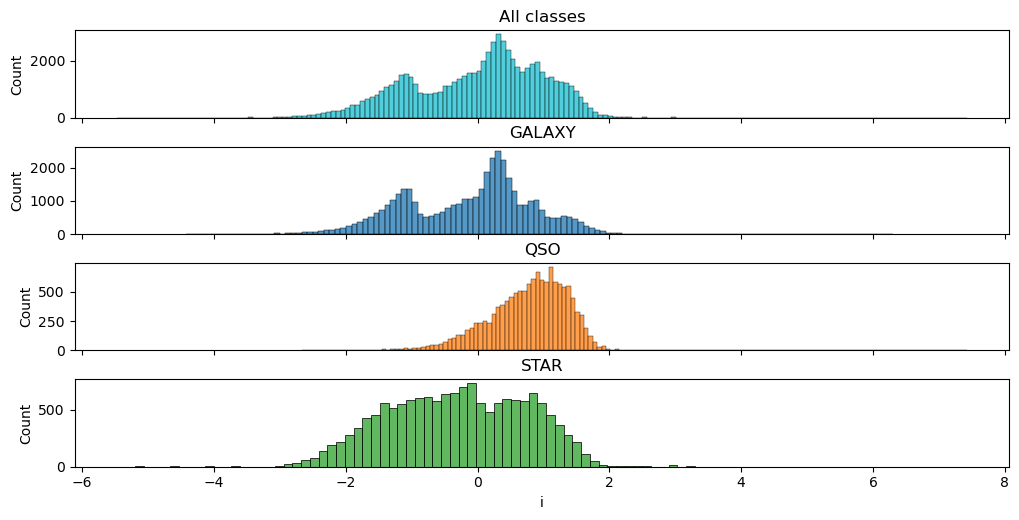

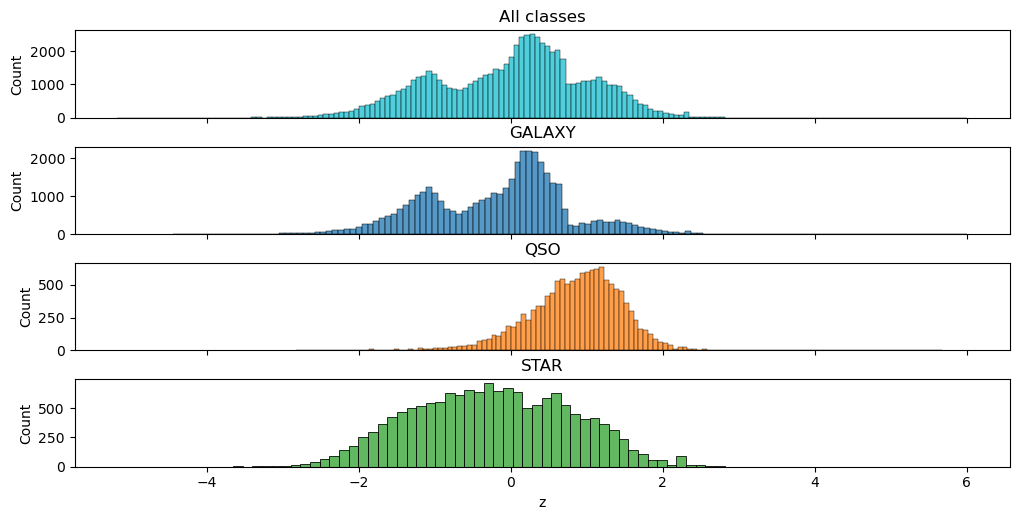

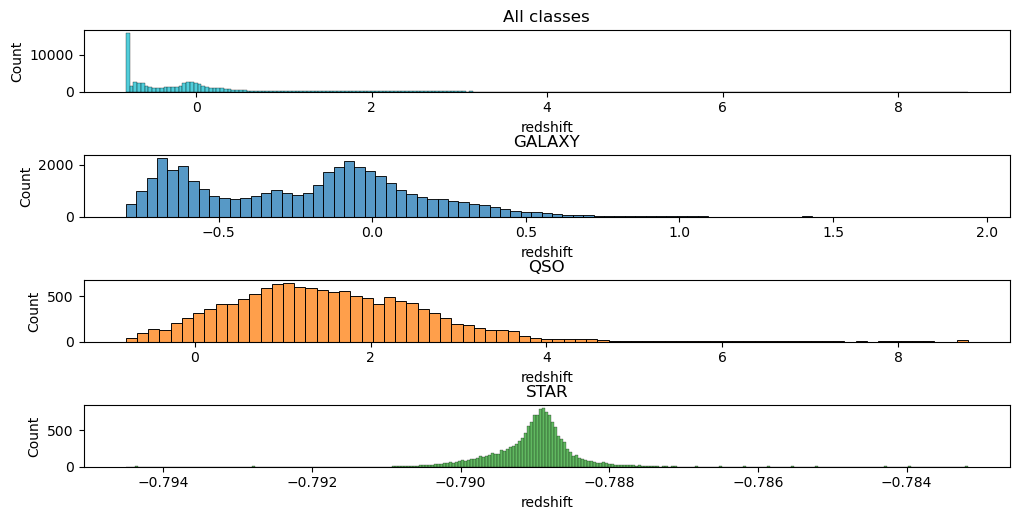

In [20]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID',]
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])

standard_distribution_info('u', True)
standard_distribution_info('g', True)
standard_distribution_info('r', True)
standard_distribution_info('i', True)
standard_distribution_info('z', True)
standard_distribution_info('redshift', False)

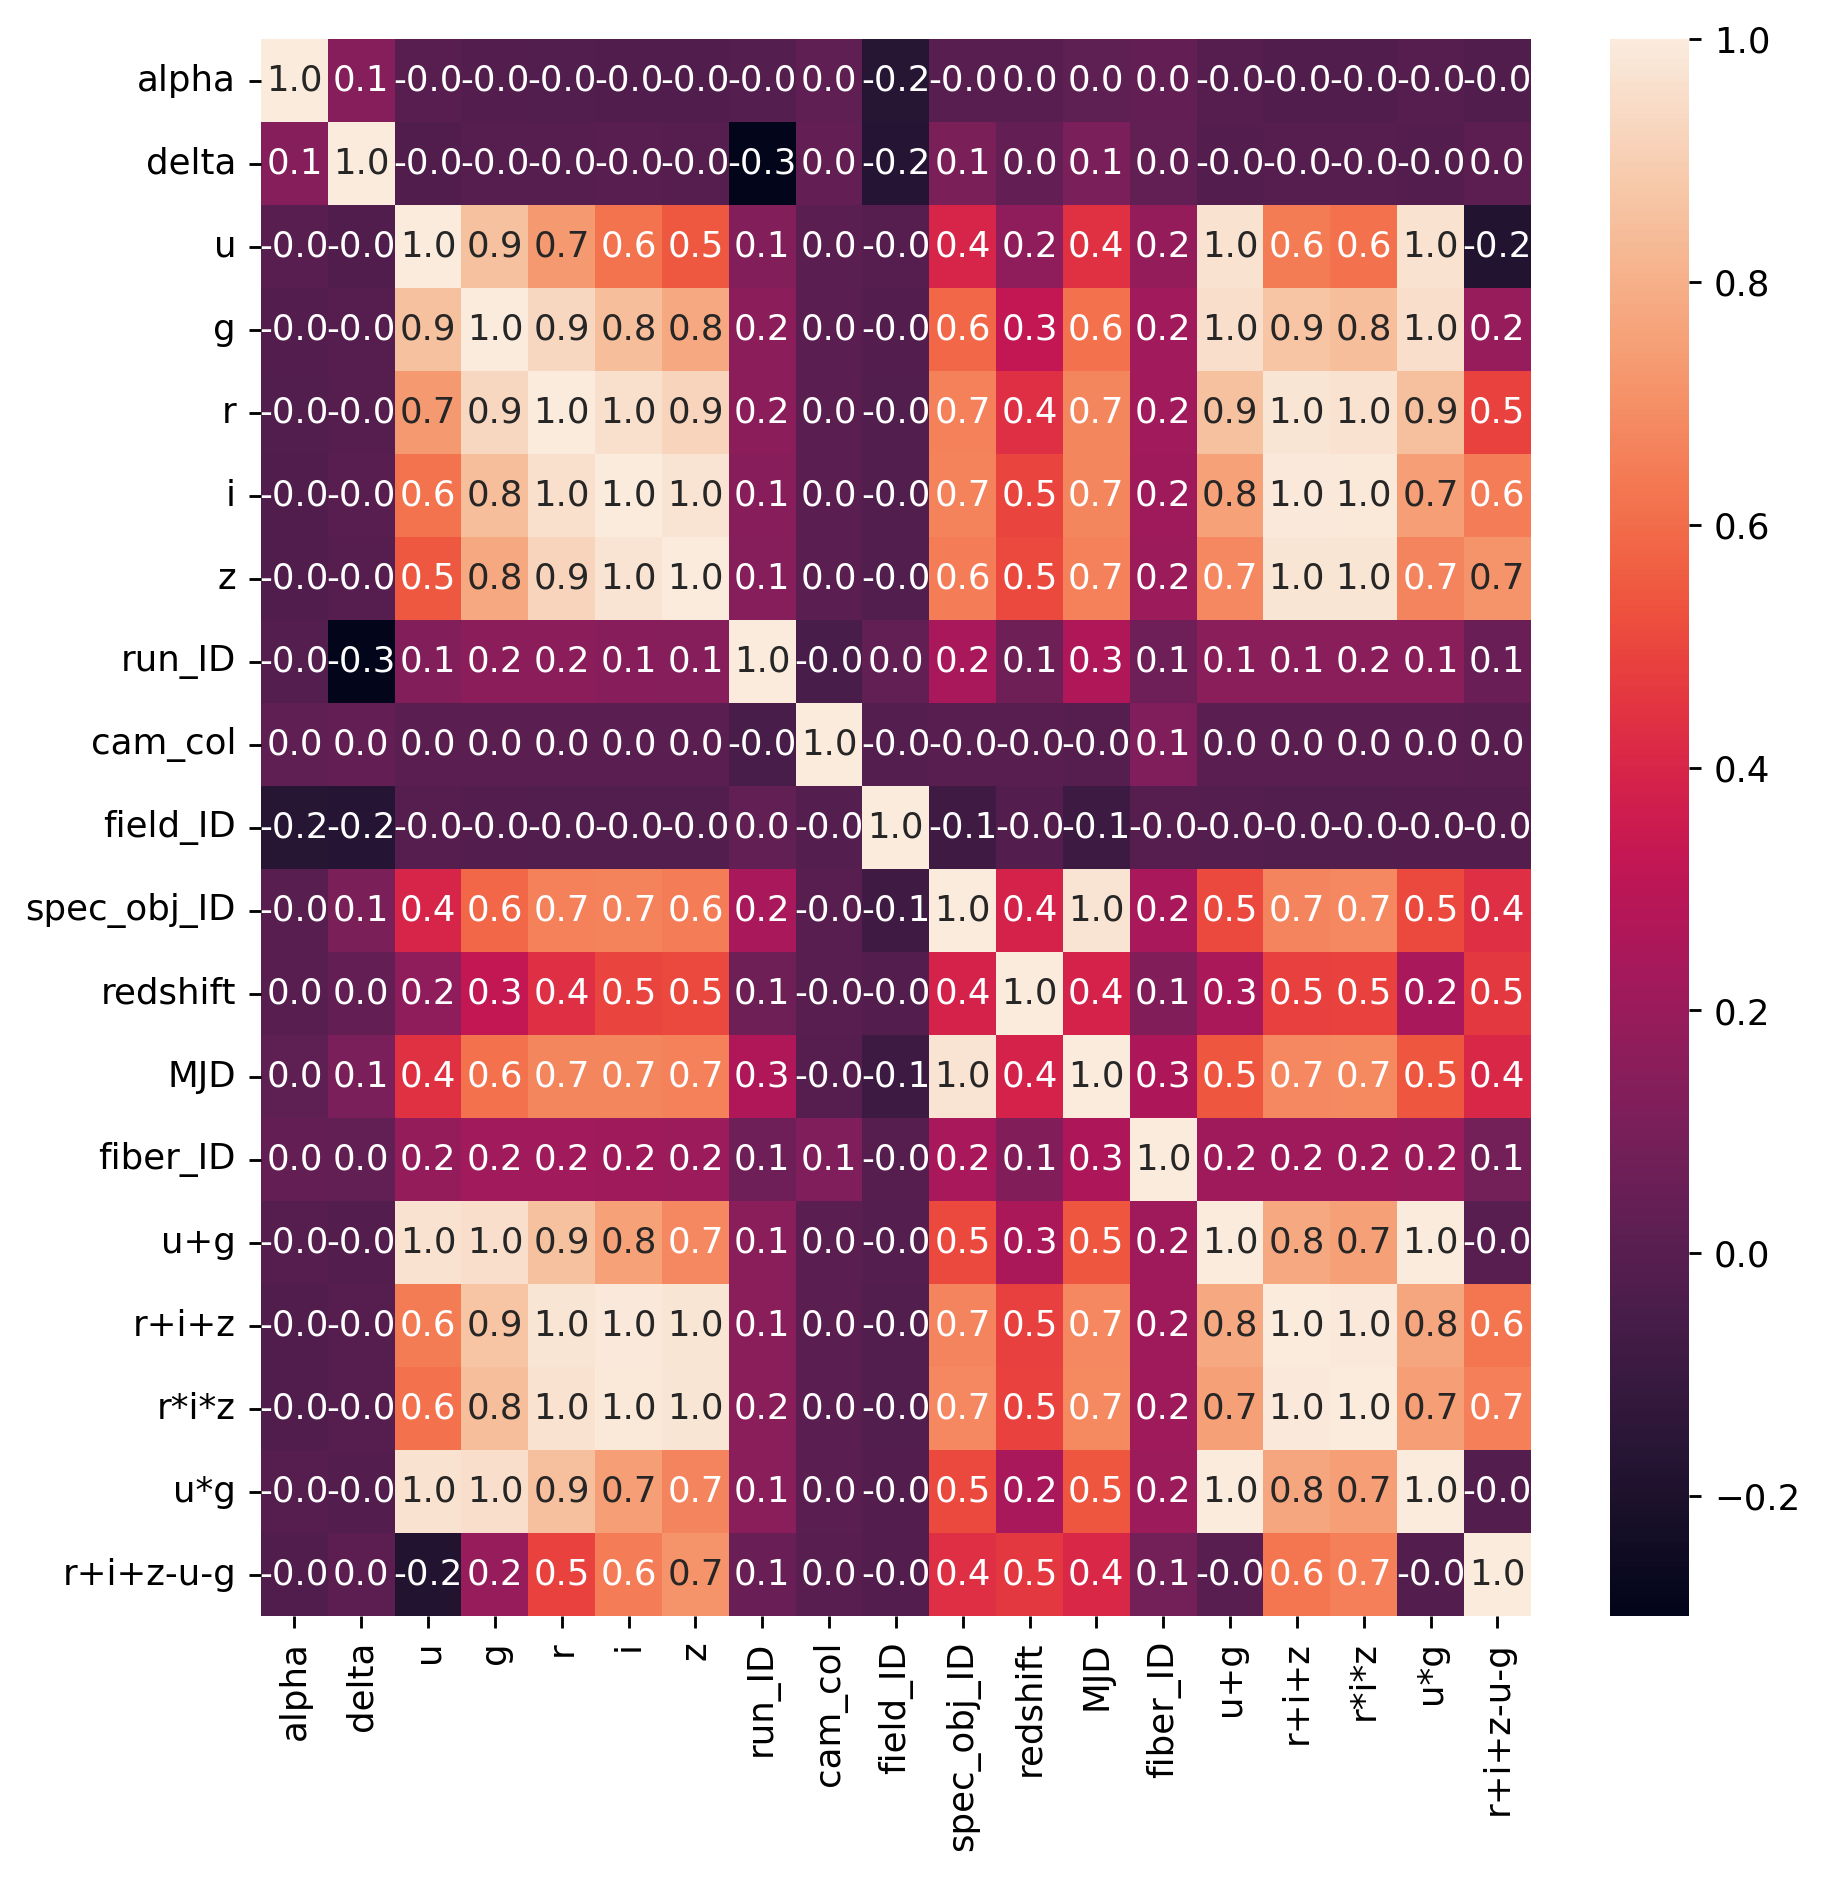

In [21]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['u+g'] = df[['u', 'g']].sum(axis=1)
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
df['r*i*z'] = df[['r', 'i', 'z']].prod(axis=1)
df['u*g'] = df[['u', 'g']].prod(axis=1)
df['r+i+z-u-g'] = df['r+i+z']-df['u+g']

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID',
                          'u+g', 'r+i+z', 'r*i*z', 'u*g', 'r+i+z-u-g']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])

df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

### Modefikacja cech opisujących filtry: u, g, r+i+z

In [22]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z'], axis = 1)

test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9555714285714285
KNeighborsClassifier: 0.9221428571428572
RandomForestClassifier: 0.9782142857142857
DecisionTreeClassifier: 0.9633571428571429
MLPClassifier: 0.9653571428571428


### Modefikacja cech opisujących filtry: u+g, r+i+z

In [23]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
df['u+g'] = df[['u', 'g']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'u+g', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)

test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9545714285714286
KNeighborsClassifier: 0.9237857142857143
RandomForestClassifier: 0.9779285714285715
DecisionTreeClassifier: 0.9623571428571429
MLPClassifier: 0.9349285714285714


### Modefikacja cech opisujących filtry: u r+i+z

In [24]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'g'], axis = 1)

test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9527857142857142
KNeighborsClassifier: 0.9230714285714285
RandomForestClassifier: 0.9767142857142858
DecisionTreeClassifier: 0.9585714285714285
MLPClassifier: 0.5947857142857143


### Modefikacja cech opisujących filtry: g, r+i+z

In [25]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u'], axis = 1)

test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9540714285714286
KNeighborsClassifier: 0.9262142857142858
RandomForestClassifier: 0.9784285714285714
DecisionTreeClassifier: 0.9617857142857142
MLPClassifier: 0.5947857142857143


### Modefikacja cech opisujących filtry: r+i+z

In [26]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)

test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9455714285714286
KNeighborsClassifier: 0.9108571428571428
RandomForestClassifier: 0.9642857142857143
DecisionTreeClassifier: 0.9428571428571428
MLPClassifier: 0.9539285714285715


### Modefikacja cech opisujących filtry: r+i+z-u-g

In [27]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['r+i+z-u-g'] = df['r']+df['i']+df['z']-df['u']-df['g']

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z-u-g']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)

test_models(df, False)

Dokładności modeli:
LogisticRegression 0.9464285714285714
KNeighborsClassifier: 0.9147857142857143
RandomForestClassifier: 0.9756428571428571
DecisionTreeClassifier: 0.9582857142857143
MLPClassifier: 0.9562142857142857


## Wybrano cechy opisujące filtry: u, g, r+i+z

### Semantyczny wybór pozostałych cech

Można wywnioskować, że numery identyfikacyjne nie mają pozytywnego wpływu na przewidywania klas obiektów.
Nawet jeśli dokładność modelu się zwiększa, przez istnienie pewnych wzorców historycznych w doborze numerów identyfikacyjnych, to nie mamy pewności, czy podobny trend będzie obecny w przyszłych/innych obserwacjach.

Współrzędne astronomiczne również nie mają znaczącego wpływu pozytywne notowania algorytmu, bo na danym obszarze nieboskłonu rozkład obiektów jest różny. Nawet, jeśli te cechy  zwiększają dokładność na pewnej próbce danych, to jak wyżej, nie mamy pewności, czy podobna tendencja zajdzie dla innego zbioru danych.

Kolumna 'fiber_ID' została odrzucona na podstawie testów - jej wpływ na dane był negatywny (ale w granicach błędu spowodowanego użorzenia się danyc w próbce).

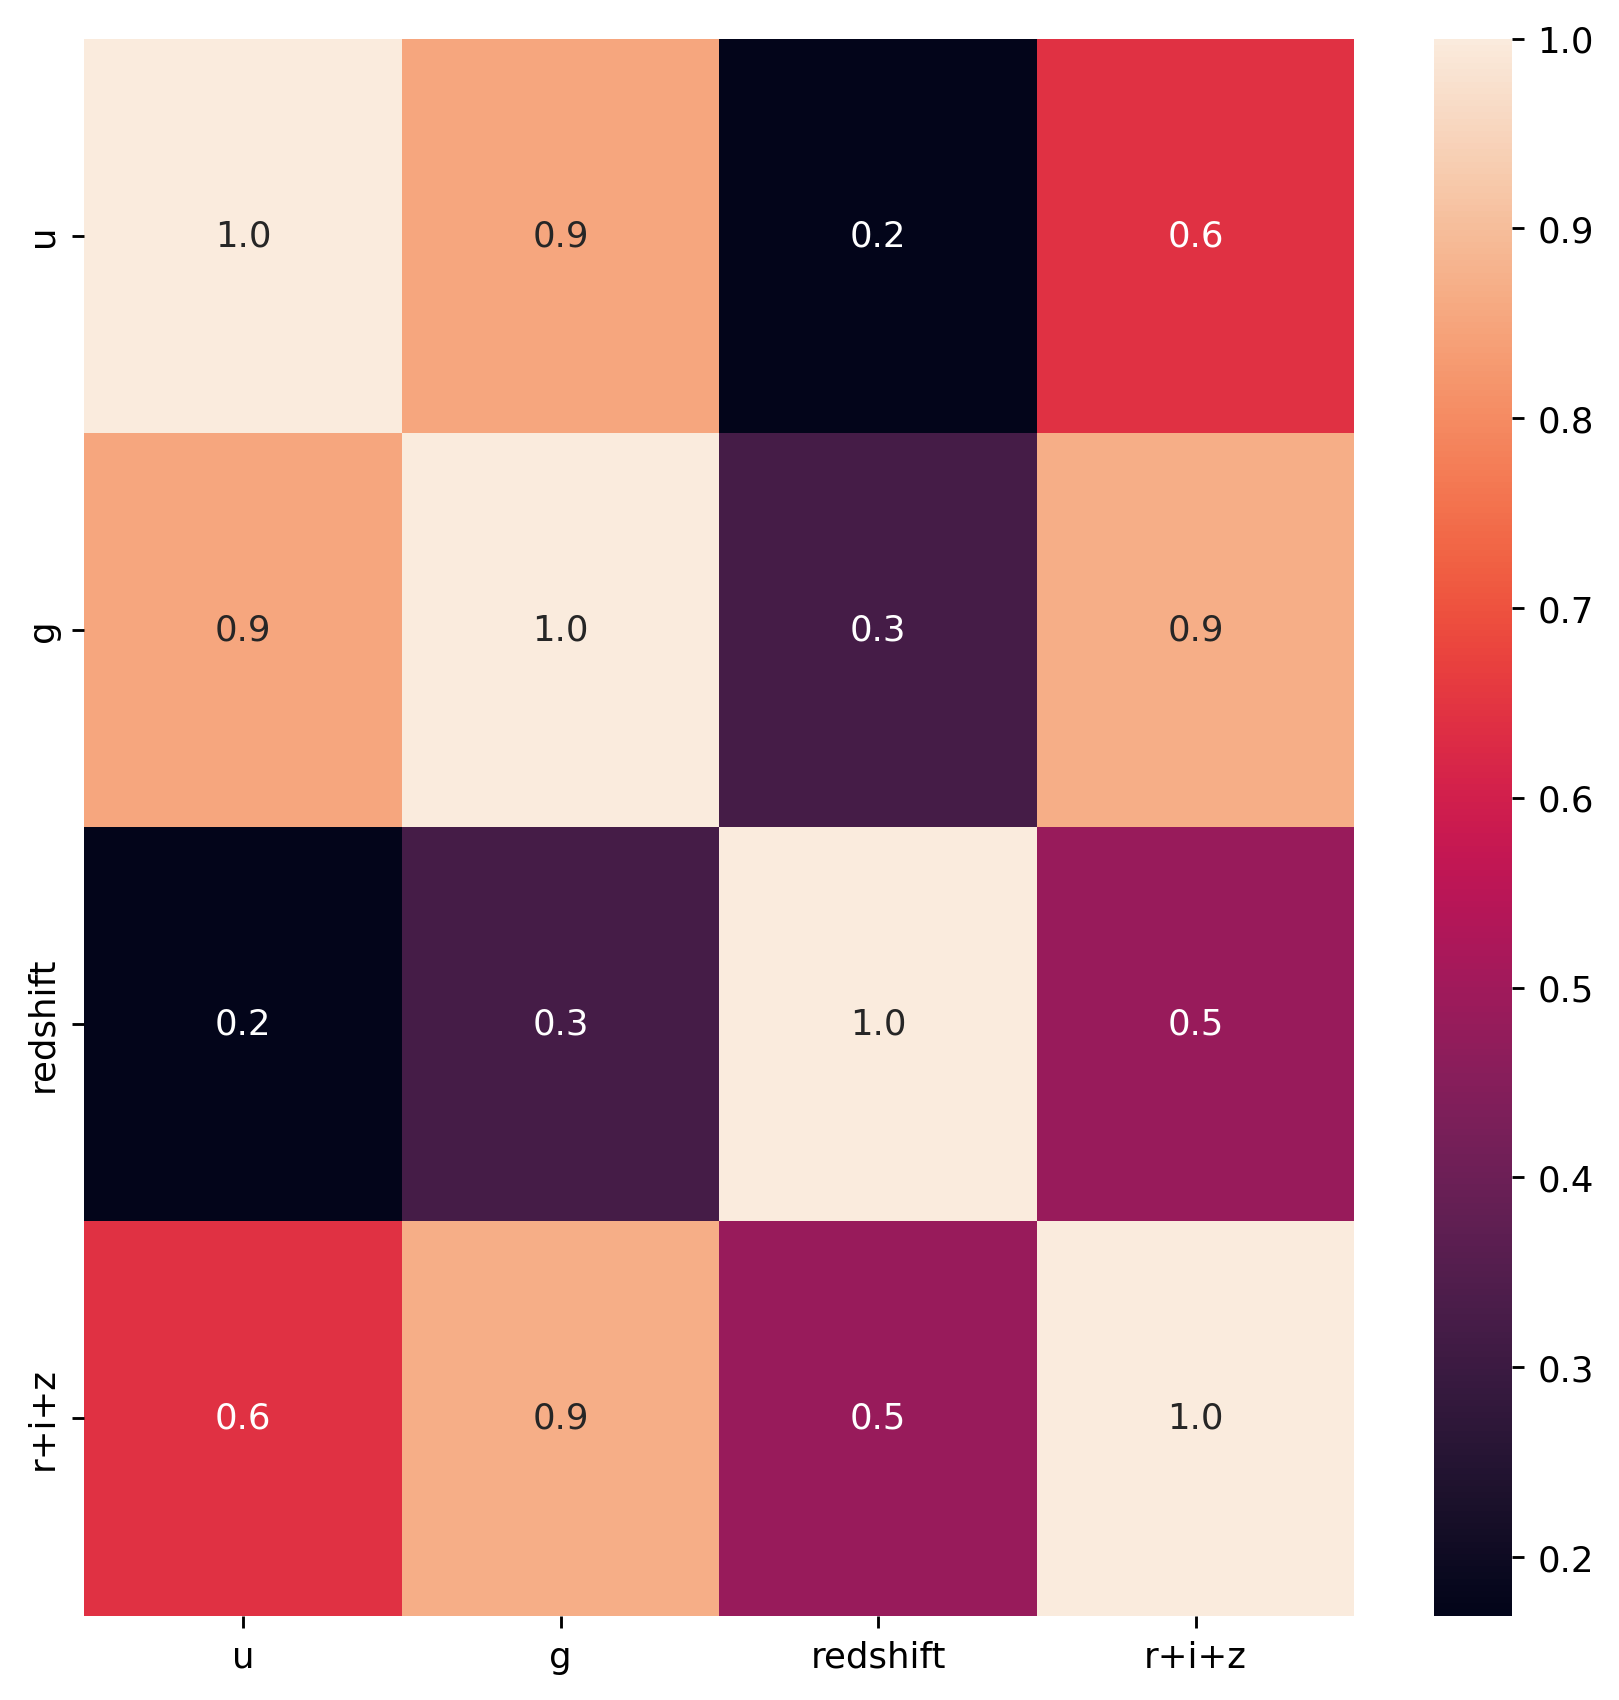

Dokładności modeli:
LogisticRegression 0.9534285714285714
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96      8327
         QSO       0.94      0.88      0.91      2627
        STAR       0.94      1.00      0.97      3046

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000

KNeighborsClassifier: 0.9610714285714286
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97      8327
         QSO       0.96      0.93      0.94      2627
        STAR       0.93      0.99      0.96      3046

    accuracy                           0.96     14000
   macro avg       0.95      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000

RandomForestClassifier: 0.9779285714285715
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.

In [33]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z'], axis = 1)

# Odrzucenie cech na podstawie interpretacji ich znaczenia
df = df.drop(['spec_obj_ID'], axis = 1) # numer obiektu
df = df.drop(['alpha'], axis = 1) # współrzędne astronomiczne
df = df.drop(['delta'], axis = 1) # współrzędne astronomiczne
df = df.drop(['field_ID'], axis = 1) # numer pola ze zdjęcia (fragment zdjęcia)
df = df.drop(['cam_col'], axis = 1) # numer kolumny ze zdjęcia (fragment zdjęcia)
df = df.drop(['run_ID'], axis = 1) # numer zdjęcia
df = df.drop(['fiber_ID'], axis = 1) # numer włókna, które skierowało światło na płaszczyznę ogniskową
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

test_models(df, True)

In [34]:
test_models_train_on_balanced(df, True)

Dokładności modeli:
LogisticRegression 0.9484775641025641
              precision    recall  f1-score   support

      GALAXY       0.93      0.92      0.92      8453
         QSO       0.95      0.92      0.94      8278
        STAR       0.97      1.00      0.99      8229

    accuracy                           0.95     24960
   macro avg       0.95      0.95      0.95     24960
weighted avg       0.95      0.95      0.95     24960

KNeighborsClassifier 0.9689503205128205
              precision    recall  f1-score   support

      GALAXY       0.97      0.94      0.95      8453
         QSO       0.96      0.97      0.97      8278
        STAR       0.97      1.00      0.99      8229

    accuracy                           0.97     24960
   macro avg       0.97      0.97      0.97     24960
weighted avg       0.97      0.97      0.97     24960

RandomForestClassifier 0.9796474358974359
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97

### Tak z ciekwości (przewidywanie na podstawie dwóch cech)

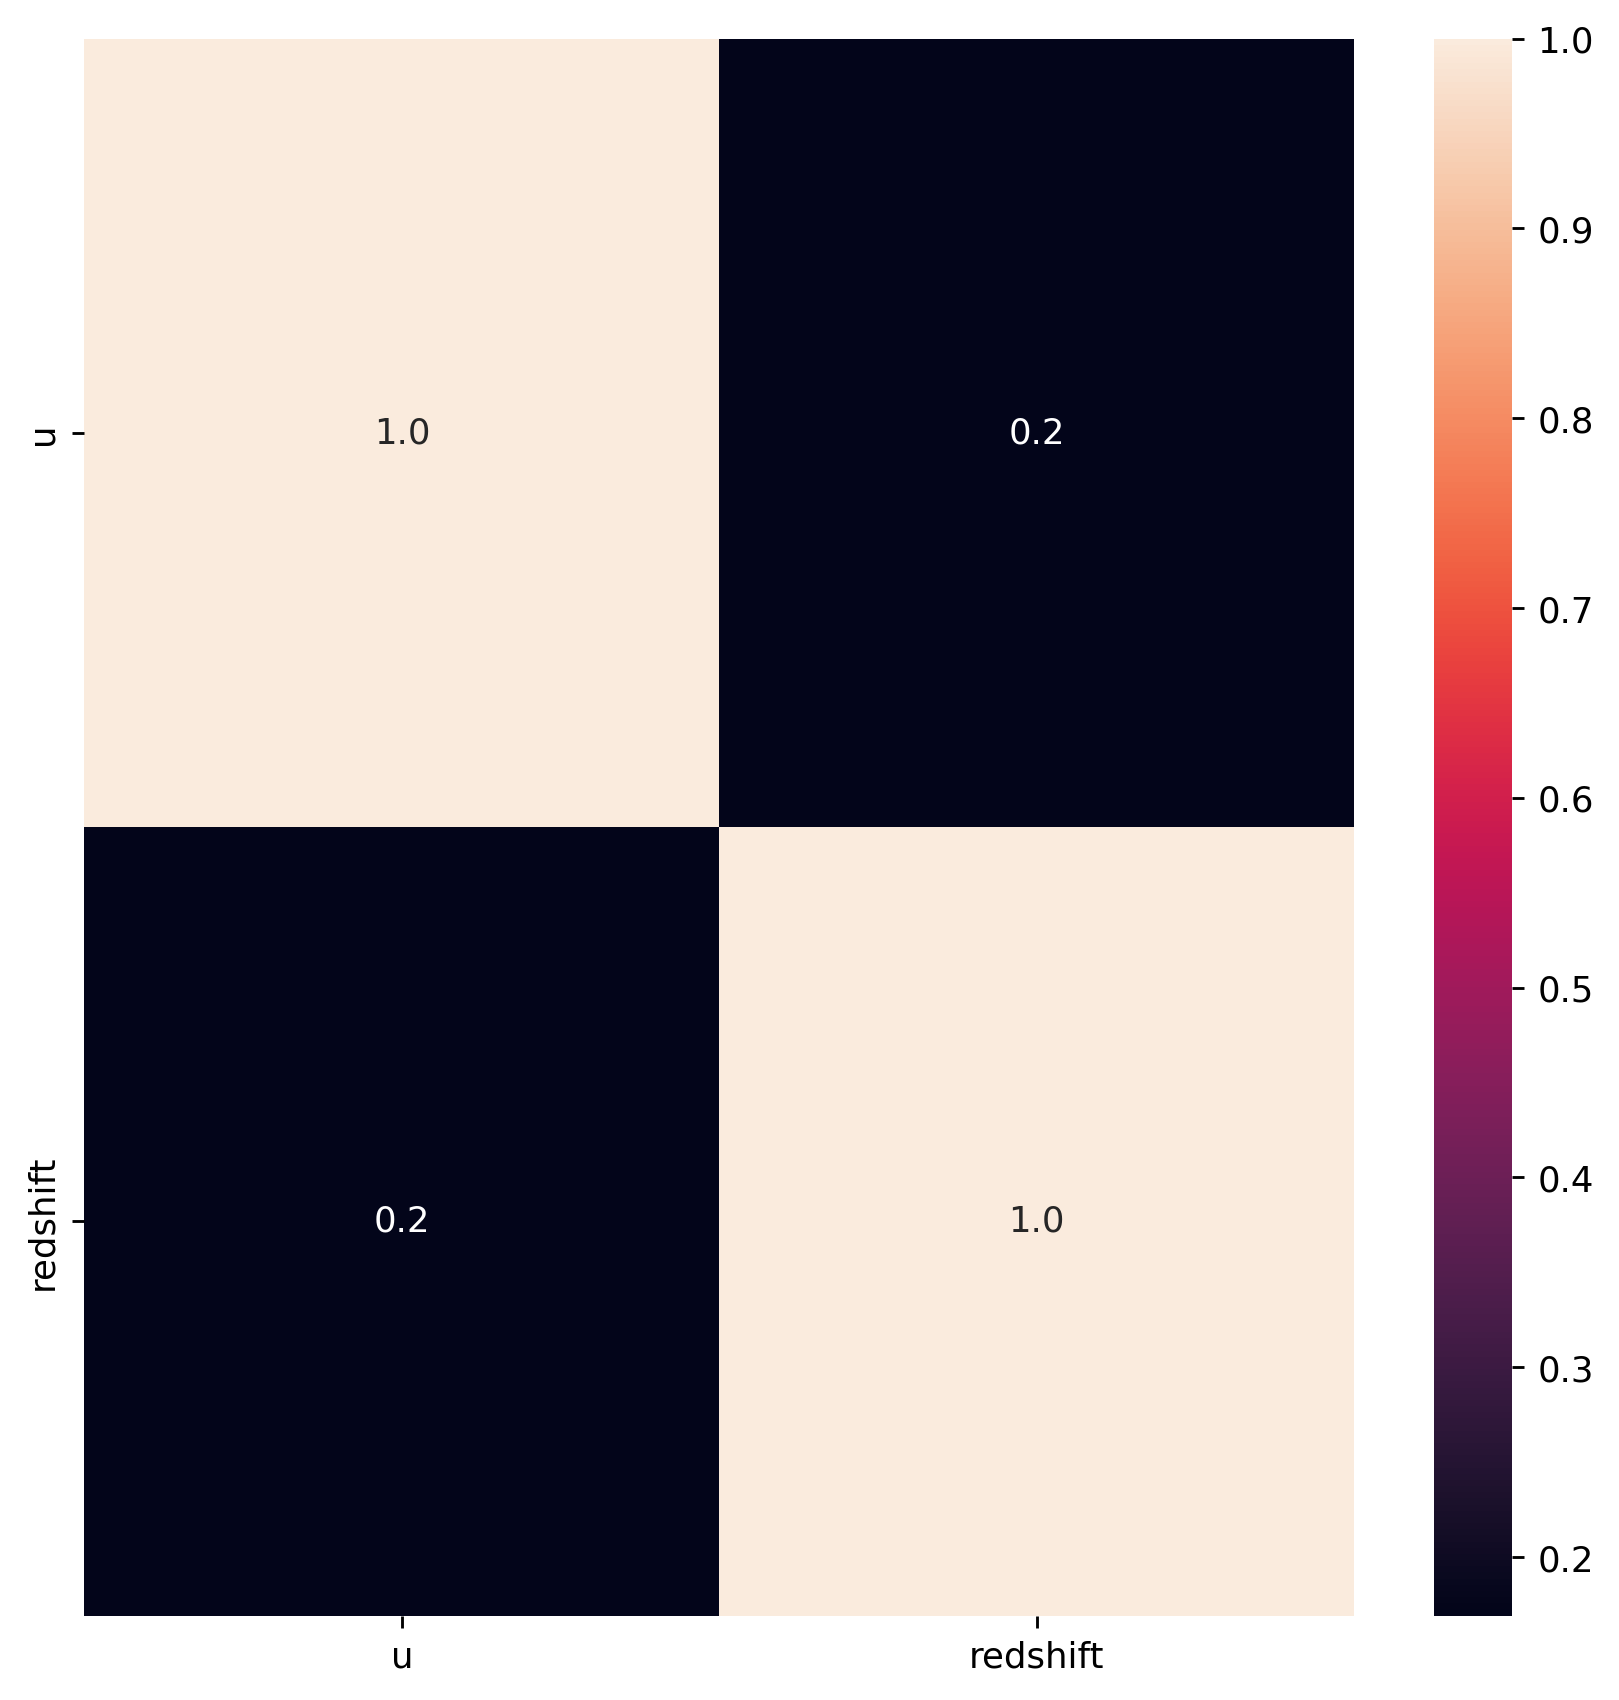

Dokładności modeli:
LogisticRegression 0.9502142857142857
KNeighborsClassifier: 0.9631428571428572
RandomForestClassifier: 0.9689285714285715
DecisionTreeClassifier: 0.9527857142857142
MLPClassifier: 0.9536428571428571


In [30]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Usuwanie kolumn
# te zostawiam
# ['u', 'redshift']
# te wyrzucam
df = df.drop(['run_ID', 'spec_obj_ID', 'MJD', 'alpha', 'cam_col', 'fiber_ID'], axis = 1)
df = df.drop(['g','r', 'i', 'z', 'delta', 'field_ID'], axis = 1)

df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

test_models(df, False)

In [31]:
test_models_train_on_balanced(df, False)

Dokładności modeli:
LogisticRegression 0.9441506410256411
KNeighborsClassifier 0.9611778846153847
RandomForestClassifier 0.9674679487179487
DecisionTreeClassifier 0.9552884615384616
MLPClassifier: 0.3296875


## Wnioski

Najbardziej znaczące cechy to te opisujące użyte filtry (czyli 'u', 'g', 'r', 'i', 'z') i 'redshift'.

Najlepsze wyniki osiąga model lasu losowego.

Klasa STAR jest przewidywana z największą dokładnością.